### PetAdoption - Capstone Project 

The dataset used is available on Kraggle's PetFinder completion done in 2019 [link](https://www.kaggle.com/competitions/petfinder-adoption-prediction/overview).  

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

The goal of the competition was to develop an algorithms to predict the adoptability of pets - specifically, how quickly is a pet adopted? If successful, it will be adapted into AI tools that will guide shelters and rescuers around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.



### Understanding the Data
The dataset is seperated into train and test data(csv) files. In addition with main data files, additional files  
* BreedLabels
* StateLabels
* ColorsLabels

for descriptive names of the values in main dataset. 

Additional/Optional data files for  

1) Images
For pets that have photos, in the format of PetID-ImageNumber.jpg. 

2) Image Metadata
Images processed via Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. File name format is PetID-ImageNumber.json.

    Google's Vision API : https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate

3) Sentiment Data
Data for each pet profile's after running through Google's Natural Language API, is provided with analysis on sentiment and key entities. 
File name format is PetID.json.

    Google Natural Language API reference: https://cloud.google.com/natural-language/docs/basics


##### The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts

### Dataset files

Will read in 4 files
* Train Data - 'data2/train/train.csv'
* Test Data  - 'data2/test/test.csv'
* Breed Data - 'data2/BreedLabels.csv'
* Color Data - 'data2/StateLabels.csv'



In [5]:
#!pip install --upgrade scikit-learn
!pip install scikit-learn==1.5.2
!pip install --upgrade imbalanced-learn
!pip install scikit-plot
!pip install category_encoders
!pip install shap
!pip install xgboost


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_score, recall_score, accuracy_score, make_scorer, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel,RFE, RFECV
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
from sklearn.metrics import mean_squared_error, get_scorer_names
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
#from category_encoders import TargetEncoder
from sklearn.preprocessing import TargetEncoder

import warnings
warnings.filterwarnings('ignore')
#!pip install category_encoders
import scikitplot as skplt
import common_fn as cf
import threshold_tuner as tt


In [7]:
# Global config object

config = cf.Config()
config.globalloglevel = 0

# Pandas options for display
pd.reset_option('display.max_columns')
pd.set_option('display.max_columns', None)

#### Provided dataset contains 2 key files
- train.csv used for training the model
- test.cdv for generating the predictions

Approach would be to load and process both train and test csv's file for processing but only use train.csv for training the file. Once the model is chosen and tuned, will use the model with test.csv file for final predictions

In [9]:
#Read in Pets data and test files
pets_file =  'data2/train/train.csv'
pets_test_file =  'data2/test/test.csv'
pets_df = pd.read_csv(pets_file)
pets_test_df = pd.read_csv(pets_test_file)


In [10]:
#Lets looks at the pets data
pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [11]:
pets_df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906       7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90       3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2

##### Process Sentiment Data
- Pets data includes a description fetaure which describes about the pet. The dataset provides a sentiment data generated using google sentiment api. We have extracted the overall mangnitude and score from all the documents into a sentiment.csv file which contains 2 features
    - documentSentiment.magnitude
    - documentSentiment.score
Will load the data and merge with pets dataset and will be used for the model  

In [13]:
# Load the sentiment file
sentiment_df = pd.read_csv('data2/train/sentiment.csv')
pets_df = pd.merge(pets_df, sentiment_df, on='PetID')

In [14]:
# Load the sentiment file for the test also
sentiment_test_df = pd.read_csv('data2/test/sentiment.csv')
pets_test_df = pd.merge(pets_test_df, sentiment_test_df, on='PetID')

In [15]:
# Adding new feature 'hasName' and dropping 'Name'

pets_df['hasName'] = np.where(pets_df.Name.notnull(), 1, 2)
pets_test_df['hasName'] = np.where(pets_test_df.Name.notnull(), 1, 2)

### We are creating 2 features 
- purebred - Y for Pure breeds, N for Cross/Mix Breed, using Breed1, Breed2 ID
- singlecolor - Y for pure color, N for anothing mixed color using Color1, Color2, Color3

In [17]:
pets_df['purebred'] = pets_df.apply(lambda x: cf.isPureBreed(x.Type, x.Breed1, x.Breed2), axis=1)
pets_df['singlecolor'] = np.where(((pets_df.Color1 > 0) & (pets_df.Color2 == 0) & (pets_df.Color3 == 0)), 1, 2)

In [18]:
# Prepare test data set as well
pets_test_df['purebred'] = pets_test_df.apply(lambda x: cf.isPureBreed(x.Type, x.Breed1, x.Breed2), axis=1)
pets_test_df['singlecolor'] = np.where(((pets_test_df.Color1 > 0) & (pets_test_df.Color2 == 0) & (pets_test_df.Color3 == 0)), 1, 2)

In [19]:
# Lets look at the target which is AdoptionSpeed
pets_df['AdoptionSpeed'] .value_counts()

AdoptionSpeed
4    4027
2    3906
3    3176
1    2949
0     384
Name: count, dtype: int64

#### The Target - AdoptionSpeed is a multiclass
* Since target variable is imbalabced, 'accuracy' is not the correct metric for benchmarking, since it become easy to get a high accuracy score by simply classifying all observations as the majority class
* F1-score which is a harmonic mean of Precision and Recall, and gives a combined idea about these two metrics. But it comes with a caveat that interpretability sometimes is a challenge since it hard to determine that classifier is maximized for - precision or recall and even more in case of muilticlass

#### So will chose performance metric as 'f1' and the average will use set to 'micro', so that we can tune for individual class in the AdoptionSpeed
 


In [21]:
config.setScoringMetric('f1')

#### Features Engineering
* For Name we created a new hasName( 1 - for Pet having name, 0 for no Name)
* For Breed1, Breed2 we created a new feature boolean purebred(1 - for purebreeds and ) for Mixed/Cross Breeeds)
* For Color1, Color2, Color3, a new feature singlecoloe is added to represent pet coloe(1 for single color, 0 for multicolor)
* PetID will be unique, so could be dropped
* RescuerID has lot of variance, so we will drop it
* For Description - can be dropped, since we already are using sentiment data generated by Google Sentiment.

In [23]:
#Let's look at current features ...
pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         14442 non-null  int64  
 1   Name                         13207 non-null  object 
 2   Age                          14442 non-null  int64  
 3   Breed1                       14442 non-null  int64  
 4   Breed2                       14442 non-null  int64  
 5   Gender                       14442 non-null  int64  
 6   Color1                       14442 non-null  int64  
 7   Color2                       14442 non-null  int64  
 8   Color3                       14442 non-null  int64  
 9   MaturitySize                 14442 non-null  int64  
 10  FurLength                    14442 non-null  int64  
 11  Vaccinated                   14442 non-null  int64  
 12  Dewormed                     14442 non-null  int64  
 13  Sterilized      

In [24]:
# We are going to remove features breed and color, since we have featured them already
cols_to_drop = ['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Name', 'PetID', 'RescuerID', 'Description', 'Unnamed: 0']

cleaned_pets_df = pets_df.drop(columns=cols_to_drop, axis=1)
cleaned_pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         14442 non-null  int64  
 1   Age                          14442 non-null  int64  
 2   Gender                       14442 non-null  int64  
 3   MaturitySize                 14442 non-null  int64  
 4   FurLength                    14442 non-null  int64  
 5   Vaccinated                   14442 non-null  int64  
 6   Dewormed                     14442 non-null  int64  
 7   Sterilized                   14442 non-null  int64  
 8   Health                       14442 non-null  int64  
 9   Quantity                     14442 non-null  int64  
 10  Fee                          14442 non-null  int64  
 11  State                        14442 non-null  int64  
 12  VideoAmt                     14442 non-null  int64  
 13  PhotoAmt        

In [25]:
final_submission_df = pets_test_df[['PetID']]
# Cleanup test data as well
pets_test_df.drop(columns=cols_to_drop, axis=1, inplace=True)

In [26]:
## Categorical features
categorical_features = ['Type', 'Gender', 'MaturitySize', 
                       'FurLength', 'Vaccinated', 'Dewormed', 
                       'Sterilized', 'Health', 'State', 'hasName', 'purebred',
                       'singlecolor']
#Numerical fetaures
numerical_features = list(set(cleaned_pets_df.drop(columns='AdoptionSpeed', axis=1).columns) - set(categorical_features))
config.categorical_features = categorical_features
config.numerical_features = numerical_features

#### We are down to 20 features with one object feature. Let's do a correlation map for more feature selection

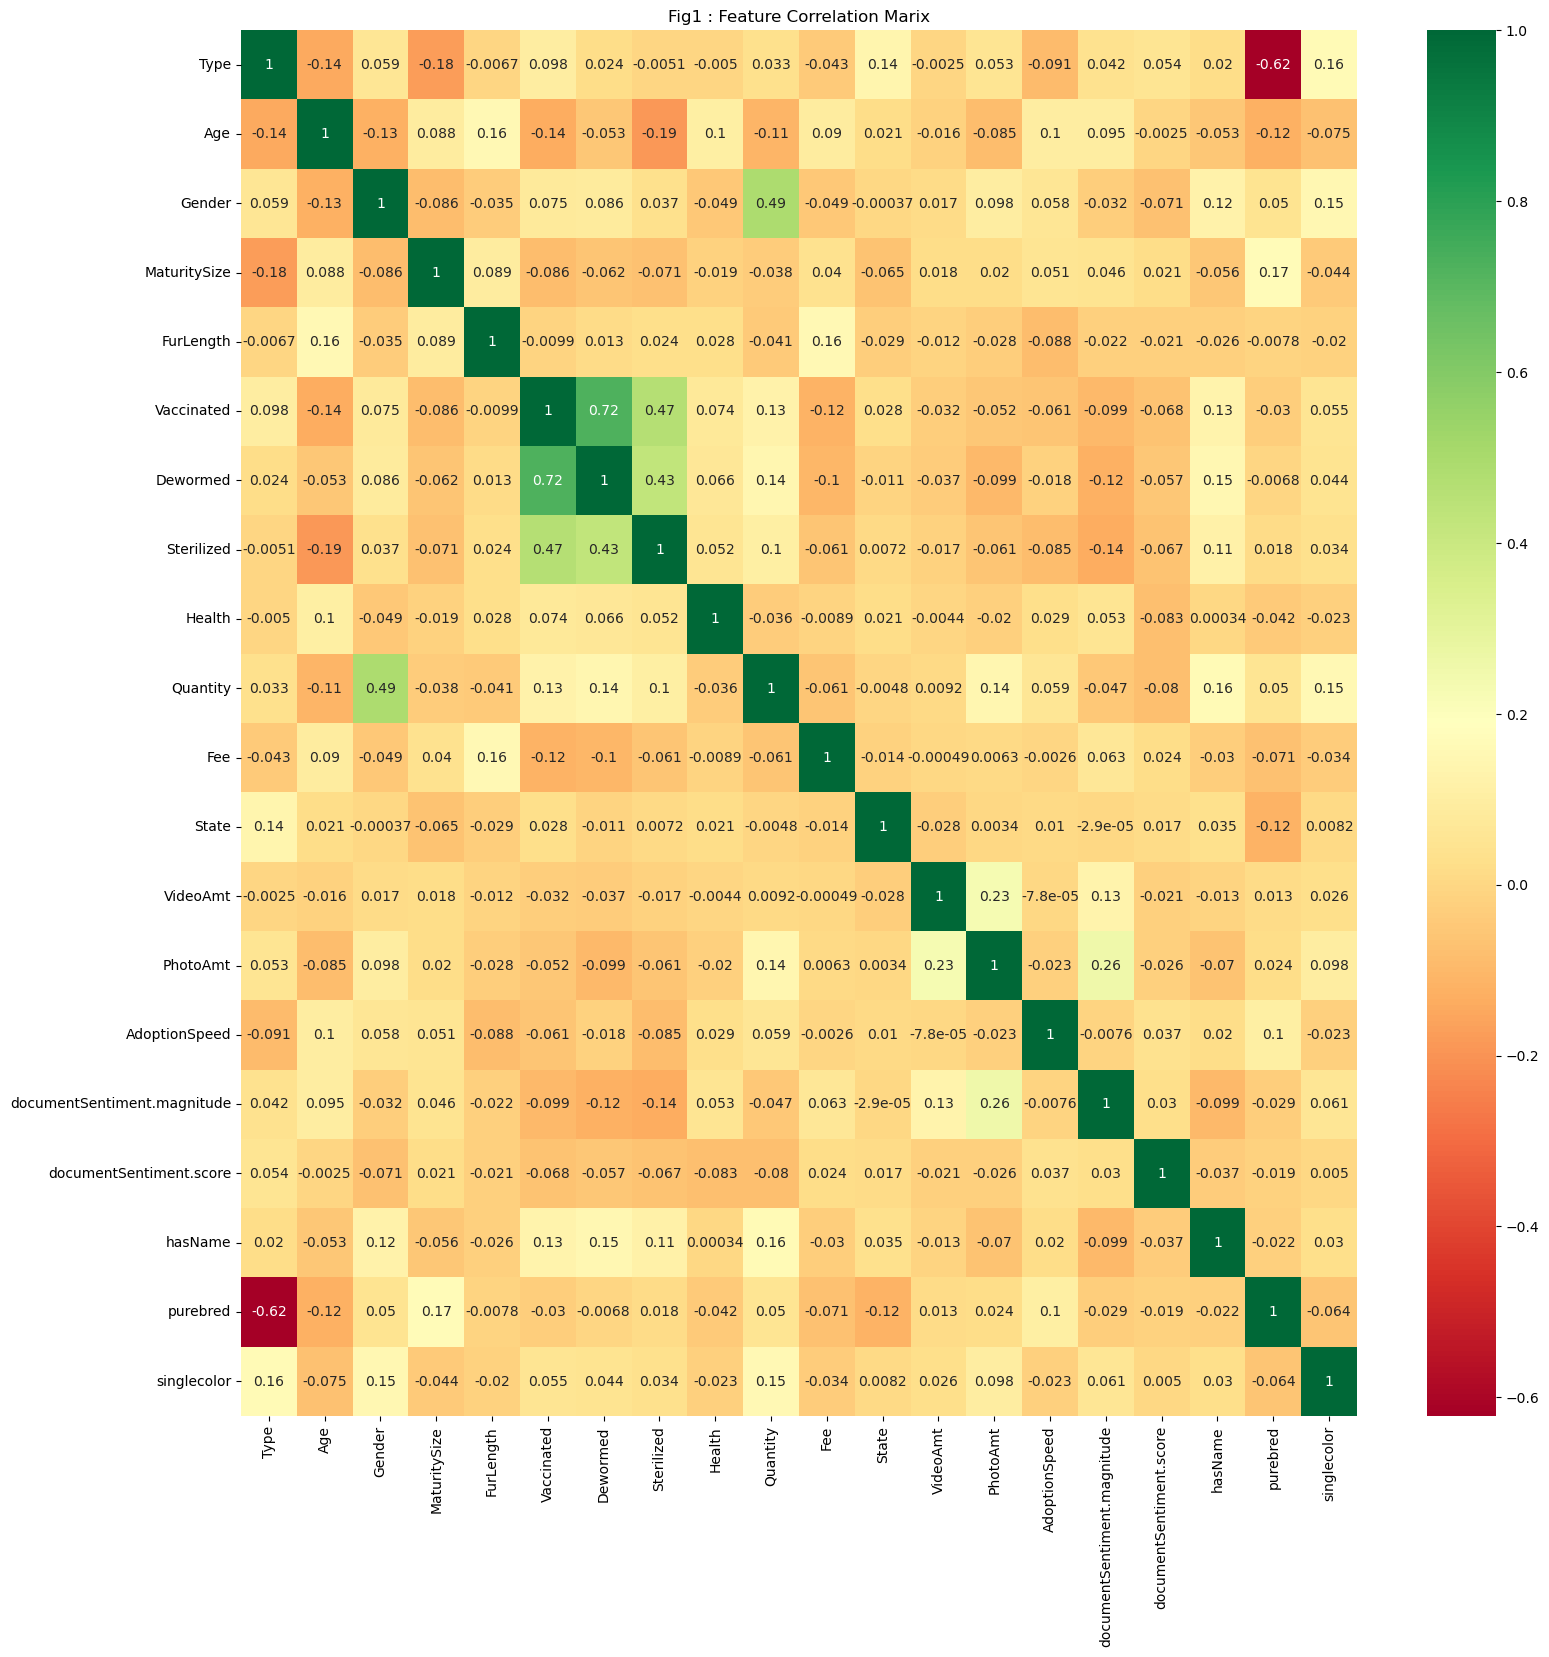

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(18,18))
corr_data = cleaned_pets_df.corr()
sns.heatmap(corr_data, annot=True, cmap='RdYlGn', ax=axs)
title, figcounter = config.getFigTitle(f'Feature Correlation Marix')
axs.set_title(title)
config.savefig(fig, title) 
fig.show();



#### Observations
* Vaccinated has strong correlation(0.72) to Dewormed
* Dewormed and Vaccinated have similar correlation to Health
* Dewormed and Vaccinated have similar correlation to Sterlized
* Type has strong correlation to purebred
* Quantity has +ve correlation ot Gender
* So we can chose to
    * keep  - Vaccinated, Quantity, Type
    * drop  - Dewormed, Type, Gender, maybe Health


### EDA is available in capstone-petfinder-EDA Notebook

## Data Modeling

### Since this is a multiclass problem will try to use a set of models and see which performs best and then choose the top 3 and will tune those models to the best one.

https://scikit-learn.org/1.5/modules/multiclass.html

- tree.DecisionTreeClassifier
- naive_bayes.GaussianNB
- neighbors.KNeighborsClassifier
- svm.LinearSVC (setting multi_class=”ovr”)
- linear_model.LogisticRegression (with most solvers)
- linear_model.LogisticRegressionCV (with most solvers)
- ensemble.RandomForestClassifier
- ensemble.GradientBoostingClassifier
- ensemble.XGBoostClassifier
- svm.LinearSVC (setting multi_class=”ovr”)
- linear_model.LogisticRegression (most solvers)

  
### Once the top 3 model is selected will use the StackingClassifier for the top 3 tuned models, to see if we can get better performance and could be used for final predictions


In [33]:
#Lets go, select X,y(target)
X = cleaned_pets_df.drop(columns=['AdoptionSpeed'])
y = cleaned_pets_df.AdoptionSpeed

#Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Will use our Dataset Holder defined in common-fn library for holding all data splits
dsholder = cf.DatasetHolder()
dsholder.update(X_train, X_test, y_train, y_test)

# Since will be using GridSearchCV, so will start with dummy_params to use the default model configuration
dummy_params = {}


#### Encoder Choice
Will run some model comparison between the following encoders to select the right encoder for our modeling
- TargetEncoder
- OnehotEncoder

Will run the encoder test against following models and compare
- LogisiticRegression
- MultiLogisticRegression
- KNearestNeighbours
- DecisionTree
- RandomForestClassifier
- GradientBoosting

##### Encoder Selection

In [36]:
# Will set the scoring metric to accuracy for encoder selectiopn
scoring_metric = 'accuracy'

# Set the scorer based on scoring metric
scorer = cf.get_custom_scorer(scoring_metric)  # Adjust average as needed
config.scorer=scorer

onehotEncoder = cf.getOnehotPreprocessor(config)
targetEncoder = cf.getPreprocessor(config)

dfs =[]
preprocessors = [('TargetEncoder', targetEncoder), ('OneHotEncoder', onehotEncoder)]
for item in preprocessors:
    name, preprocessor = item 
    processor_config = config
    print(f'****************** {name} ****************************')
    pipelinefactory = cf.PipelineFactory(preprocessor)
    # Run pipelines and collect data
    processor_config = cf.run_pipelines(pipelinefactory, dsholder, processor_config, True)
    # Dump the results of tuned classifier comparison
    results_df = cf.dump_df(processor_config)
    results_df = results_df.set_index('Model')
    results_df.drop(['Best Params','Train Time','Train Accuracy', 'Test MSE'], axis=1, inplace=True)
    results_df.rename(columns={'Test Accuracy': f'{name}'}, inplace=True)
    dfs.append(results_df)


****************** TargetEncoder ****************************
=========== Executing - Logistic Regression ================
Train Score=0.36947274705707783, Test Score=0.34525732748672977, Mean_fit_time=0.14114747047424317
{}
=========== Executing - Multi Logistic Regression ================
Train Score=0.3713522603620536, Test Score=0.345718901453958, Mean_fit_time=0.2527143955230713
{}
=========== Executing - KNN ================
Train Score=0.5231971510535167, Test Score=0.3069466882067851, Mean_fit_time=0.04674577713012695
{}
=========== Executing - Decision Tree ================
Train Score=0.5103373231773667, Test Score=0.32310177705977383, Mean_fit_time=0.20062828063964844
{}
=========== Executing - Random Forest ================
Train Score=0.6822633297062024, Test Score=0.39672282483267945, Mean_fit_time=1.6782854080200196
{}
=========== Executing - Gradient Boosting ================
Train Score=0.4413888614106242, Test Score=0.39279944611123935, Mean_fit_time=11.04956970214843

In [37]:
#### Encoder Comparison
combined_df = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)
combined_df

TargetEncoder  OneHotEncoder
Model                                                  
Logistic Regression             0.345257       0.351258
Multi Logistic Regression       0.345719       0.352412
KNN                             0.306947       0.312486
Decision Tree                   0.323102       0.336026
Random Forest                   0.396723       0.399031
Gradient Boosting               0.392799       0.394646

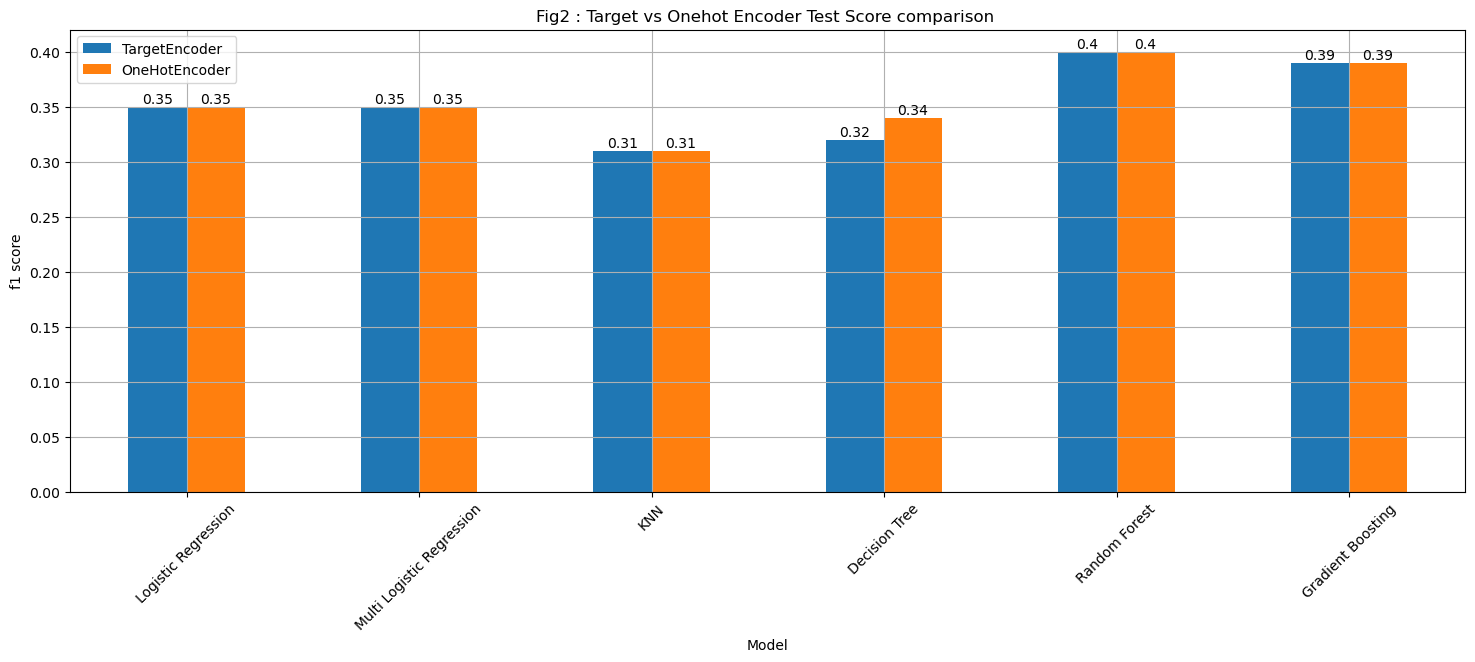

In [38]:
figcounter = cf.cust_bar_plot(combined_df, f'Target vs Onehot Encoder Test Score comparison ', 
              config, 'encoder_comparison.png')

#### Observations
- LogisiticRegression perform similar to both type of Encoders
- KNearestNeighbours and DecisionTree are performing better with OneHoldEncoder
- RandomForestClassifier which has the best score from the comparison set is slighly better with TargetEncoder, so will select TargetEncoder as our choice

In [40]:
# Set to targetEncoder as the preprocessor
config.preprocessor = targetEncoder

#### Modeling Approach
* Prep
    * Prepare X, y dataset 
    * Use TargetEncoer to encode/transform categorical features
    * Use StandardScaler for scaling numeric values
    * Check the encoder columns and shape of new dataset
    * Create a PipelineFactory for varipous Models
* Score a Baseline Model using LogisticRegression
* Perform Feature Selection to improve scores
* Run various model pipelines with default config, to seek the best model
* Analysis for best model
    * Score
    * Confusion Matrix, ROC Curve
    * Observations
* Select the top3 models
* Tune the models
    * Hyperparameter Tuning
    * Threshold Tuning
* Create a StackingClassifier - see if we out perform the top3 model  
* Select the best model
* Predict using the test dataset


### Preparation

Prepare for train and test split set. We have test data to do some predictions. We perform that towards the end once we are able to establish a tuned model with high f1 score

In [43]:
#Perform Train/test split
X = cleaned_pets_df.drop(columns=['AdoptionSpeed'])
y = cleaned_pets_df.AdoptionSpeed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Capture the splits in a dataset
dsholder = cf.DatasetHolder()
dsholder.update(X_train, X_test, y_train, y_test)

# Set default parama as empty for all Grid searched
dummy_params = {}

#Set the scoring metric as f1, since it is multiclass, use averge as 'micro' for multiclass
scoring_metric = 'f1'
config.scoring_metric = scoring_metric
scorer = cf.get_custom_scorer(scoring_metric, average='micro')  
config.scorer=scorer


# Create a preprocessor object with TargetEncoder
preprocessor = config.preprocessor

# Create pipeline factory again
pipelinefactory = cf.PipelineFactory(preprocessor)


### Baseline Model

Use Logistic Regression to build a basic model for the data.  

=========== Executing - Logistic Regression ================
Train Score=0.32357305371451184, Test Score=0.3191783983383337, Mean_fit_time=0.19250378608703614
{'classifier__class_weight': 'balanced'}
Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.05      0.21      0.08       125
           1       0.29      0.34      0.31       906
           2       0.34      0.16      0.22      1159
           3       0.29      0.27      0.28       886
           4       0.45      0.49      0.47      1257

    accuracy                           0.32      4333
   macro avg       0.28      0.30      0.27      4333
weighted avg       0.34      0.32      0.32      4333



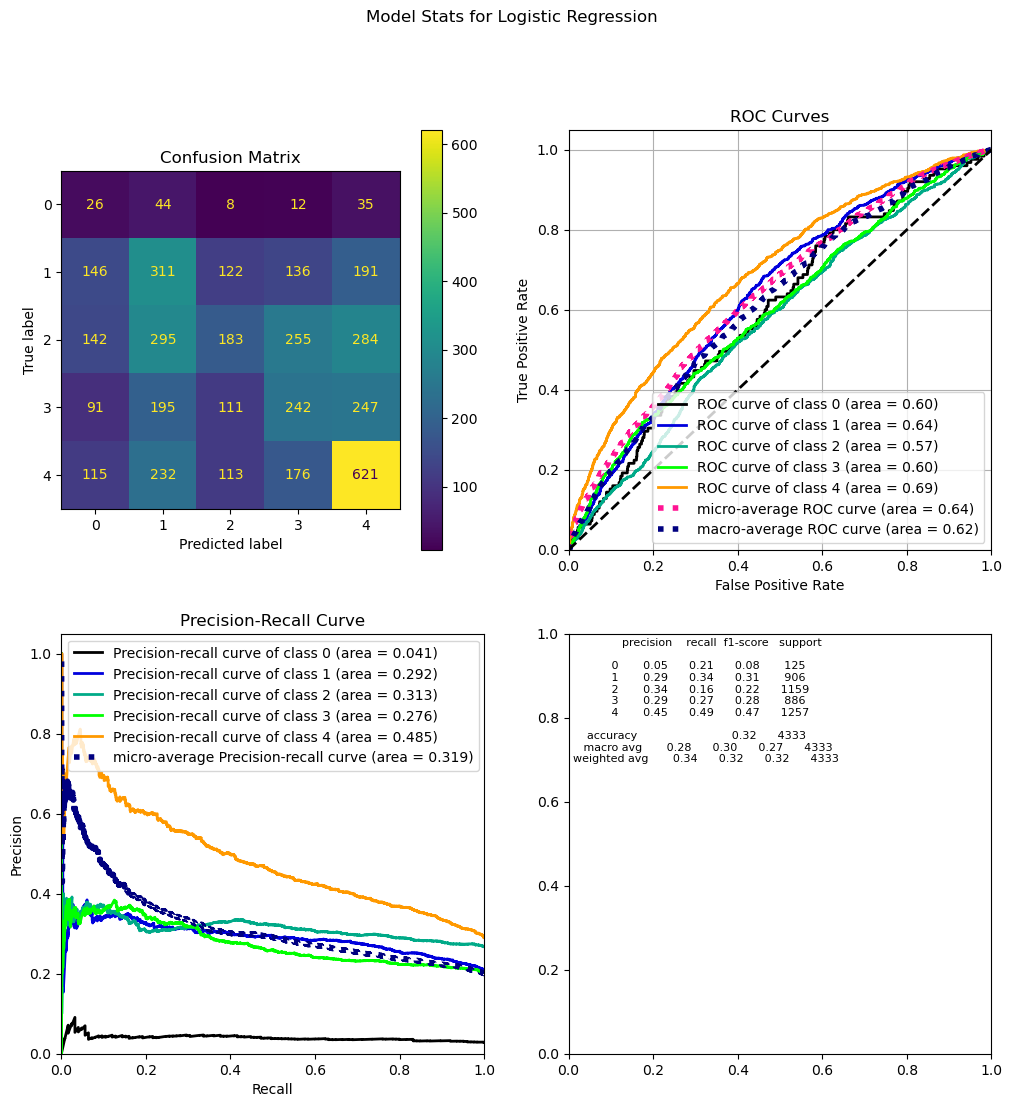

In [45]:
# Now we have some results for 'accuracy' metric. The tests the transformer/encoding and scaler. 
# Now let's run in the Pipeline and print stats

# Since it ia multi-class which is imbalanced class set, will set class_weights parameter
default_params = {
        'classifier__class_weight' : ['balanced'],
        } 

config.init_globals()
lgr_pipe = cf.perform_test(GridSearchCV(pipelinefactory.lgr, param_grid=default_params, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Logistic Regression', config, dsholder)
cf.show_logistic_model_stats(dsholder, lgr_pipe, 'Logistic Regression', config)

#### Since the score is not that high, will try setting class weights and see if we can get better score

In [47]:

# Calculate class weights
from sklearn.utils import class_weight

classes_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y))

classweight_params = {
        'classifier__class_weight' : [{0:classes_weights[0],
                                        1:classes_weights[1],
                                        2:classes_weights[2],
                                        3:classes_weights[3],
                                        4:classes_weights[4]}],
        } 

cf.perform_test(GridSearchCV(pipelinefactory.lgr, param_grid=classweight_params, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Logistic Regression', config, dsholder)

=========== Executing - Logistic Regression ================
Train Score=0.3130873479078049, Test Score=0.306715901223171, Mean_fit_time=0.16279959678649902
{'classifier__class_weight': {0: 7.521875, 1: 0.9794506612410987, 2: 0.7394777265745007, 3: 0.9094458438287154, 4: 0.7172585050906382}}


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['documentSentiment.magnitude',
                                                                          'PhotoAmt',
                                                                          'Fee',
                                                                          'Quantity',
                                                                          'Age',
                                                                          'VideoAmt',
                                                                          'documentSentiment.score']),
                                                                        ('cat',
                                                                         TargetEncoder(random_state=42),
                                                                         ['Type',
                                                                          'Gender',
                                                                          'MaturitySize',
                                                                          'FurLength',
                                                                          'Vaccinate...
                                                                          'Health',
                                                                          'State',
                                                                          'hasName',
                                                                          'purebred',
                                                                          'singlecolor'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'classifier__class_weight': [{0: 7.521875,
                                                       1: 0.9794506612410987,
                                                       2: 0.7394777265745007,
                                                       3: 0.9094458438287154,
                                                       4: 0.7172585050906382}]},
             scoring=make_scorer(f1_score, response_method='predict', average=micro))

#### Observations
- Using default settings for LogisticRegression with class weights as 'balanced' have score of 0.32 not very high
    - Train = 0.323573053714511842
    - Test = 0.3191783983383337
    - Confusion Matric - The classwise predictions of labels across the diagonal in the very
- Even choosing class_weights and setting did not help much, infact the score is even less to 0.30
- So will default to 'balanced' settings

#### Can LinearRegression perform better, since most of the data is numeric, even if it is categorical

In [50]:
## Attempt to run as a LinearRegression

linear_config = config
linear_categorical_features = []

#Numerical fetaures
linear_numerical_features = list(set(cleaned_pets_df.drop(columns='AdoptionSpeed', axis=1).columns) - set(linear_categorical_features))
linear_config.categorical_features = linear_categorical_features
linear_config.numerical_features = linear_numerical_features
linear_config.scoring_metric = 'accuracy'
linear_config.scorer = cf.get_custom_scorer(linear_config.scoring_metric)

ss = StandardScaler()

X_linear = cleaned_pets_df.drop(columns=['AdoptionSpeed'])
y_linear = cleaned_pets_df.AdoptionSpeed
#y_scaled = ss.fit_transform(cleaned_pets_df[['AdoptionSpeed']])
#y_linear = pd.Series(y_scaled[:,0])
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.3, random_state=42)
dsholder_linear = cf.DatasetHolder()
dsholder_linear.update(X_train_linear, X_test_linear, y_train_linear, y_test_linear)
linear_tranformer = cf.getPreprocessor(linear_config)
linear = Pipeline([
    ('transformer',  linear_tranformer),
    ('model', LinearRegression(fit_intercept=True) )
])

linear.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Gender',
                                                   'documentSentiment.magnitude',
                                                   'State', 'Age', 'Vaccinated',
                                                   'FurLength', 'MaturitySize',
                                                   'Health', 'hasName',
                                                   'PhotoAmt', 'Fee',
                                                   'Quantity', 'Sterilized',
                                                   'purebred', 'singlecolor',
                                                   'Type', 'VideoAmt',
                                                   'Dewormed',
                                                   'documentSentiment.score']),
                                                 ('cat',
                                                  TargetEncoder(random_state=42),
                                                  [])])),
                ('model', LinearRegression())])

In [51]:
linear.score(X_train_linear, y_train_linear)

0.05416256790396934

#### Observation 
* Tried to run the data as a LinearRegression, since all always are numeric, but it only produces 5% accuracy
  


## Feature Selection
Let's perform some feature selection to see if it can help to improve the model scores furthur.
Since it is multiclass target and not continonus distribution, will perform L1 regularization penalty with LogisticRegression

##### Remember:  Because we are using regularization, it is important to have each of the features represented on the same scale.

In [54]:
# Let's run SelectFromModel to get a list of selected features.
selector = ''
best_features = ''

config.categorical_features = categorical_features
config.numerical_features = numerical_features

selector = SelectFromModel(estimator=LogisticRegression(C=0.1, 
                                                        penalty = 'l1',
                                                        solver='liblinear',
                                                        random_state=42,
                                                        class_weight='balanced',
                                                        multi_class='ovr'))
feature_selector_pipe = Pipeline([
    ('transformer', preprocessor),
    ('selector', selector),
    ('lgr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', multi_class='ovr'))
])

#Fit the pipe and extract the selected features
X_train, X_test, y_train, y_test = dsholder.get()

feature_selector_pipe.fit(X_train,y_train)
test_score = float(feature_selector_pipe.score(X_test, y_test))
selected_features = feature_selector_pipe.named_steps['selector'].get_support()
# To select which features to drop
features_to_drop = []

# Convert the encoded and scaled featured selected as  True, False to actual names
chosen_features_list = cf.selected_columns_list(
    feature_selector_pipe.named_steps['transformer'].get_feature_names_out(), 
    selected_features)
chosen_processed_features = []
for feature_name in chosen_features_list:
    chosen_processed_features.append((str(feature_name.split('_')[2])))
selected_features = np.unique(chosen_processed_features)
features_to_drop = list(set(X.columns) - set(selected_features))
print('Features to Drop = ', features_to_drop)


Features to Drop =  ['Gender', 'hasName', 'singlecolor', 'Health', 'Dewormed']


In [55]:
transformed_features_list = feature_selector_pipe.named_steps['transformer'].get_feature_names_out()

##### Observation
- Earlier observation also found 'Gender' as a feature can be dropped

In [57]:

## X_train and y_train is balanced with SMOTE'd
X_train, X_test, y_train, y_test = dsholder.get()

#Drop the features
X_train_trimmed = X_train.drop(columns=features_to_drop, axis=1)
X_test_trimmed = X_test.drop(columns=features_to_drop, axis=1)
pets_test_df = pets_test_df.drop(columns=features_to_drop, axis=1)

# After featue drop update the set of categorical and numerical features for encoder in pipelines
config.categorical_features = list(set(config.categorical_features) - set(features_to_drop))
config.numerical_features = list(set(config.numerical_features) - set(features_to_drop))



In [58]:
# Update the Real X for final predictions
X = X.drop(columns=features_to_drop, axis=1)
dsholder_final = cf.DatasetHolder()
dsholder_final.update(X, pets_test_df, y, y)

# Hold the original dataset, will be used for SMOTE
dsholder_org = cf.DatasetHolder()
dsholder_org.update(X, X, y, y)

In [59]:
# Create a new preprocessor object with TargetEncoder, since we dropped lot of features
preprocessor = cf.getPreprocessor(config)
config.preprocessor = preprocessor

# Create pipeline factory again
pipelinefactory = cf.PipelineFactory(preprocessor)

# Create a new Datasetholder with update columns
dsholder2 = cf.DatasetHolder()
dsholder2.update(X_train_trimmed, X_test_trimmed, y_train, y_test)

=========== Executing - Logistic Regression ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.3223859926797903, Test Score=0.3164089545349642, Mean_fit_time=0.16498661041259766
{'classifier__class_weight': 'balanced'}
Classification Report - Feature Selection -Logistic Regression-f1
              precision    recall  f1-score   support

           0       0.05      0.20      0.08       125
           1       0.29      0.35      0.32       906
           2       0.32      0.15      0.20      1159
           3       0.30      0.28      0.29       886
           4       0.45      0.48      0.47      1257

    accuracy                           0.32      4333
   macro avg       0.28      0.29      0.27      4333
weighted avg       0.34      0.32      0.32      4333



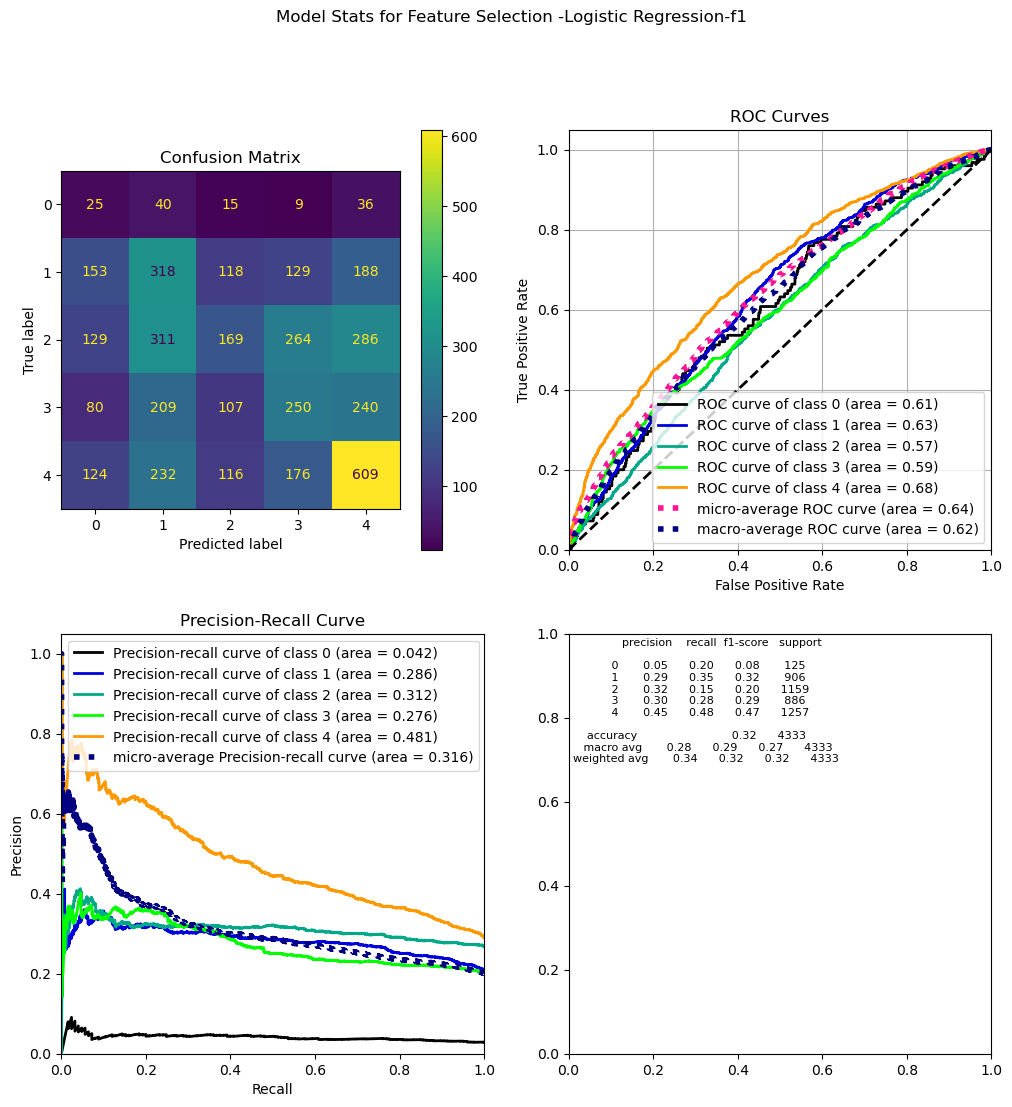

In [60]:
# Update the dataset holder and run the pipelines to see if we improve on the score
config.globalloglevel = 1
config.init_globals()

# Setting back the scorer to f1, since it was set to accuracy for feature selection
scoring_metric = 'f1'
config.scoring_metric = scoring_metric
scorer = cf.get_custom_scorer(scoring_metric, average='micro')  # Adjust average as needed
config.scorer=scorer

# Rerun the LogisticRegression pipeline 

lgr_pipe = cf.perform_test(GridSearchCV(pipelinefactory.lgr, param_grid=default_params, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Logistic Regression', config, dsholder2)
cf.show_logistic_model_stats(dsholder2, lgr_pipe,  
                             f'Feature Selection -Logistic Regression-{scoring_metric}', config)

#### Observations
- Removing the features did not impact the score, which is good

### Feature Importance
- Lets see what are importance features

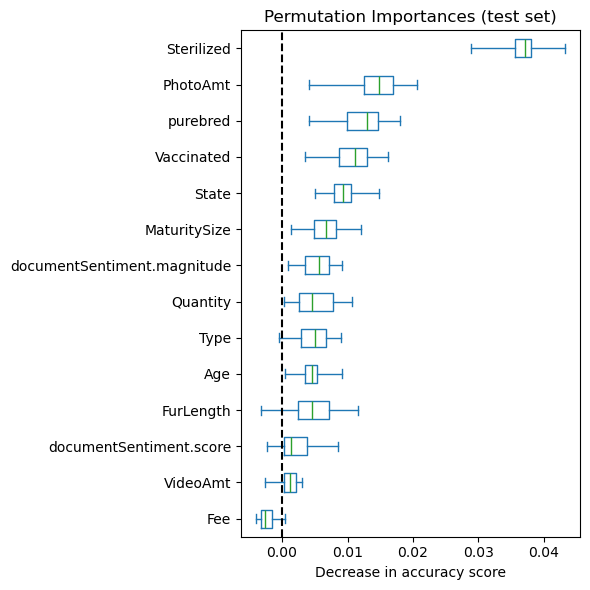

In [63]:
X_train, X_test, y_train, y_test = dsholder2.get()
config.scoring_metric = 'accuracy'
config.scorer = cf.get_custom_scorer(config.scoring_metric)
cf.plot_feature_imp(dsholder2, config, lgr_pipe, X_test.columns)

#### Observations
- Sterlized seems to be top feature
- PhotoAmt and purebred(curated features) are next in the list
- Fee's seems to be unimportant


#### Run various pipelines for different type of classifiers to performs score evaluation. 
Using GridSearch for each pipeline, even if the params are empty. Will run the following pipelines
* LogisiticRegression(multimodal)
* OneVsRest
* OneVsOne
* KNeighborsClassifier(kNN)
* DecisionTreeClassifier
* Support Vector Machine(SVM)
* Ensemble models
    * RandomForest 
    * Voting
    * AdaBoost
    * GradientBoosting
    * XGBoost 

The results will be captured in a DataFrame for comparison  


In [66]:
config.dummy_params = default_params
scoring_metric = 'f1'
config.scoring_metric = scoring_metric
scorer = cf.get_custom_scorer(scoring_metric, average='micro')  # Adjust average as needed
config.scorer=scorer
config = cf.run_pipelines(pipelinefactory, dsholder2, config)

=========== Executing - Logistic Regression ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.3223859926797903, Test Score=0.3164089545349642, Mean_fit_time=0.14413557052612305
{'classifier__class_weight': 'balanced'}
=========== Executing - OneVsOne ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.3637352853892571, Test Score=0.356796676667436, Mean_fit_time=0.1316455841064453
{}
=========== Executing - OneVsRest ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.3630428331190029, Test Score=0.35610431571659357, Mean_fit_time=0.10788159370422364
{}
=========== Executing - Multi Logistic Regression ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.36363636363636365, Test Score=0.3570274636510501, Mean_fit_time=0.17394552230834961
{}
=========== Executing - KNN ================
Fitting 5 folds for each of 1 candidates, totalling 

## Model Comparisons

Now, we aim to compare the performance of all the model 

In [68]:
# Dump the results of tuned classifier comparison
results_df = cf.dump_df(config)
results_df = results_df.set_index('Model')
results_df.drop('Best Params', axis=1)

Train Time  Train Accuracy  Test Accuracy  Test MSE
Model                                                                         
Logistic Regression          0.144136        0.322386       0.316409   2.78929
OneVsOne                     0.131646        0.363735       0.356797   2.08170
OneVsRest                    0.107882        0.363043       0.356104   2.07708
Multi Logistic Regression    0.173946        0.363636       0.357027   2.06093
KNN                          0.031711        0.521021       0.310408   2.36972
Decision Tree                0.142339        0.538431       0.308331   2.36995
SVC                          5.653019        0.336235       0.295869   3.17424
Random Forest                1.578763        0.685528       0.404339   1.90999
Voting Ensemble              0.350073        0.537244       0.342488   2.33372
AdaBoost                     5.668880        0.547334       0.325179   2.30279
Gradient Boosting            7.871792        0.439312       0.411724   1.88876
XGBoost                      0.539792        0.551786       0.399031   1.93123

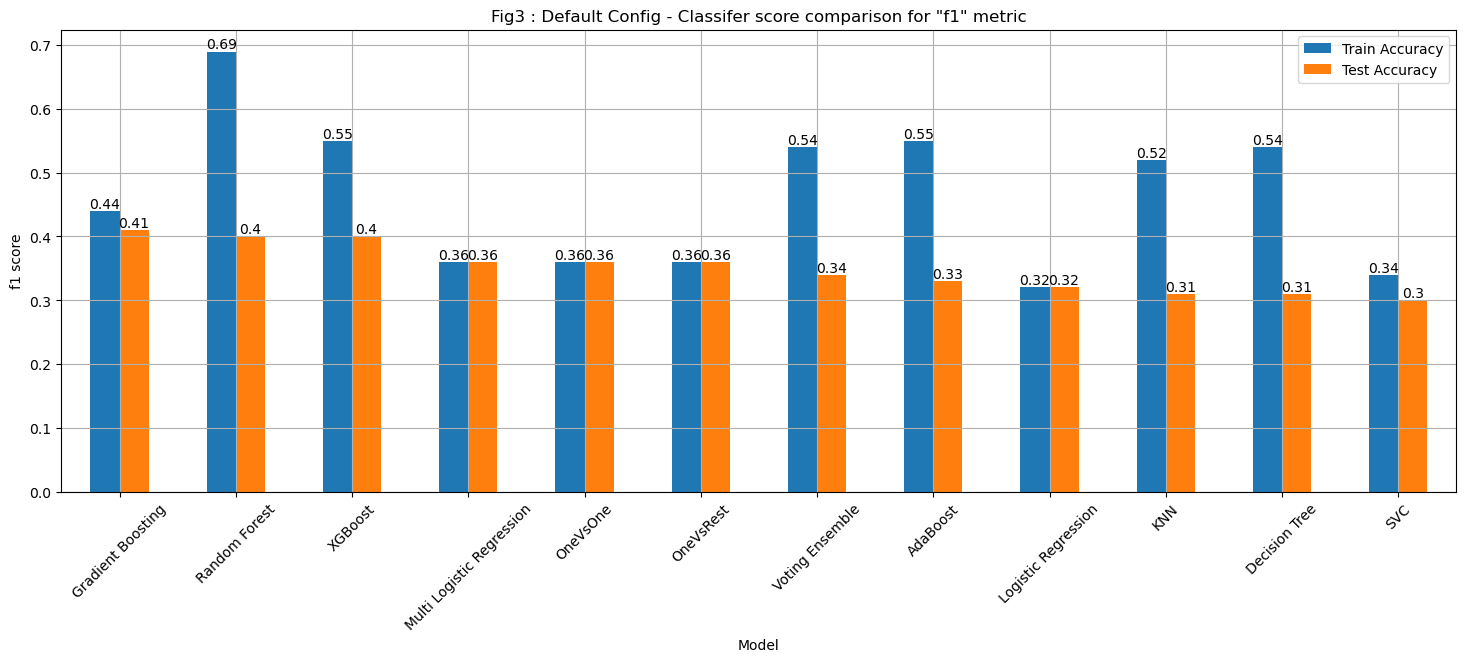

In [69]:
# Lets plot to see the scores. The results are sorted by Test Scores.
figcounter = cf.cust_bar_plot(results_df[['Train Accuracy', 'Test Accuracy']].sort_values(
    'Test Accuracy', ascending=False), f'Default Config - Classifer score comparison for "{scoring_metric}" metric', 
              config, 'model_default_comparison.png')

#### Observations
- Gradient Boosting has the best score of 41%
- Followed closely by XGBoost abd RandomForest at 40%
- RandomForest has a training score of 69%, so it possible that is overfitted

In [71]:
## Use the data to find Best classifier from the current run

before_tuning_best_model = cf.select_top_classifier(results_df)
print(f'Best Model before tuning = {before_tuning_best_model}')

Best Model before tuning = Gradient Boosting


Classification Report - Gradient Boosting(Default) - f1-score
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.38      0.31      0.34       906
           2       0.35      0.47      0.40      1159
           3       0.36      0.14      0.20       886
           4       0.49      0.66      0.56      1257

    accuracy                           0.41      4333
   macro avg       0.32      0.32      0.30      4333
weighted avg       0.39      0.41      0.38      4333



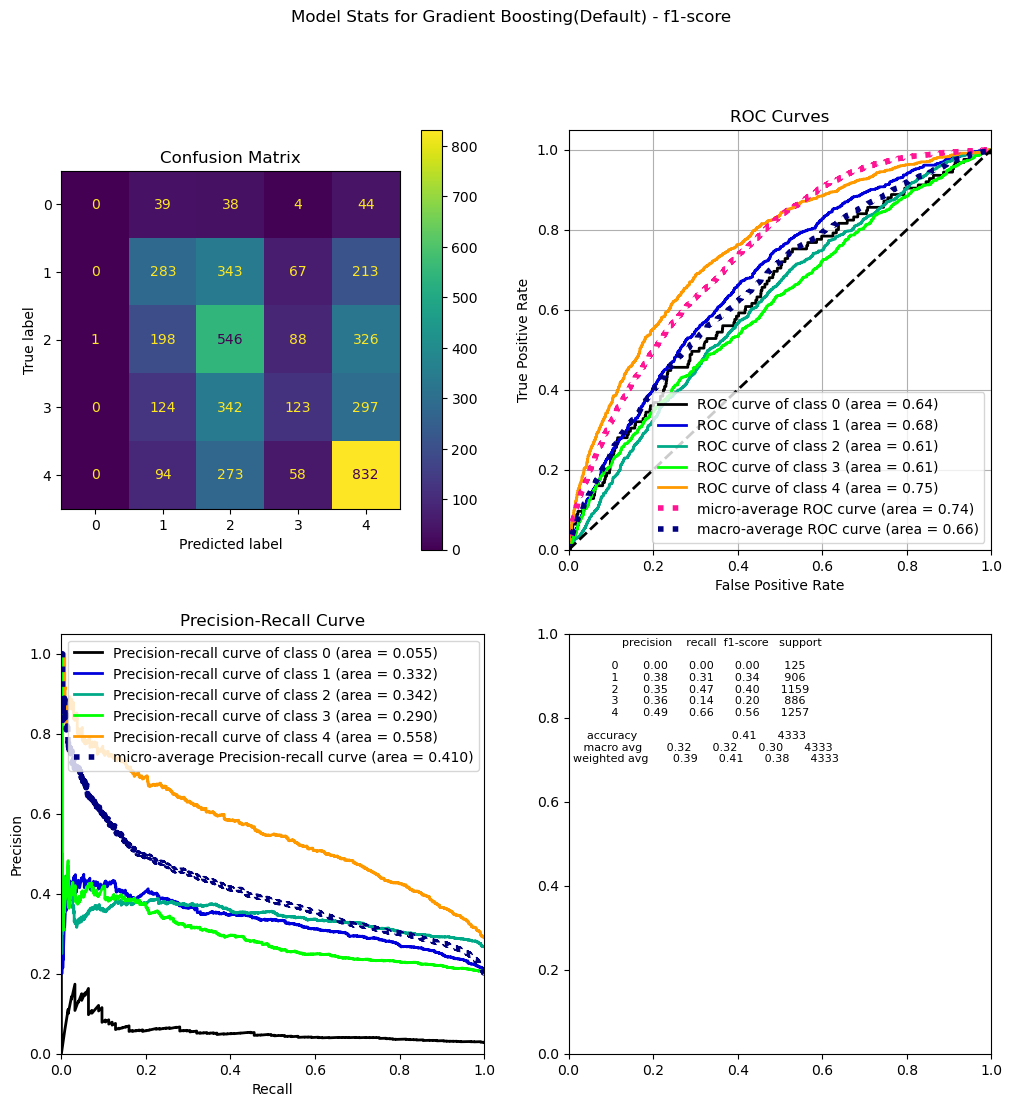

In [72]:
#Let's also check the stats for the best_model, since it has the highest, train and test score
best_grid = cf.find_best_pipe(
    before_tuning_best_model, 
    pipelinefactory.lgr, 
    pipelinefactory.multi_lgr, 
    pipelinefactory.onevsone, 
    pipelinefactory.onevsrest, 
    pipelinefactory.knn, 
    pipelinefactory.tree,
    pipelinefactory.rnforest, 
    pipelinefactory.voting,
    pipelinefactory.ada, 
    pipelinefactory.gbc,
    pipelinefactory.svc,
    pipelinefactory.stacking,
    pipelinefactory.xgb
)
cf.show_logistic_model_stats(dsholder2, best_grid,  f'{before_tuning_best_model}(Default) - {scoring_metric}-score', config)

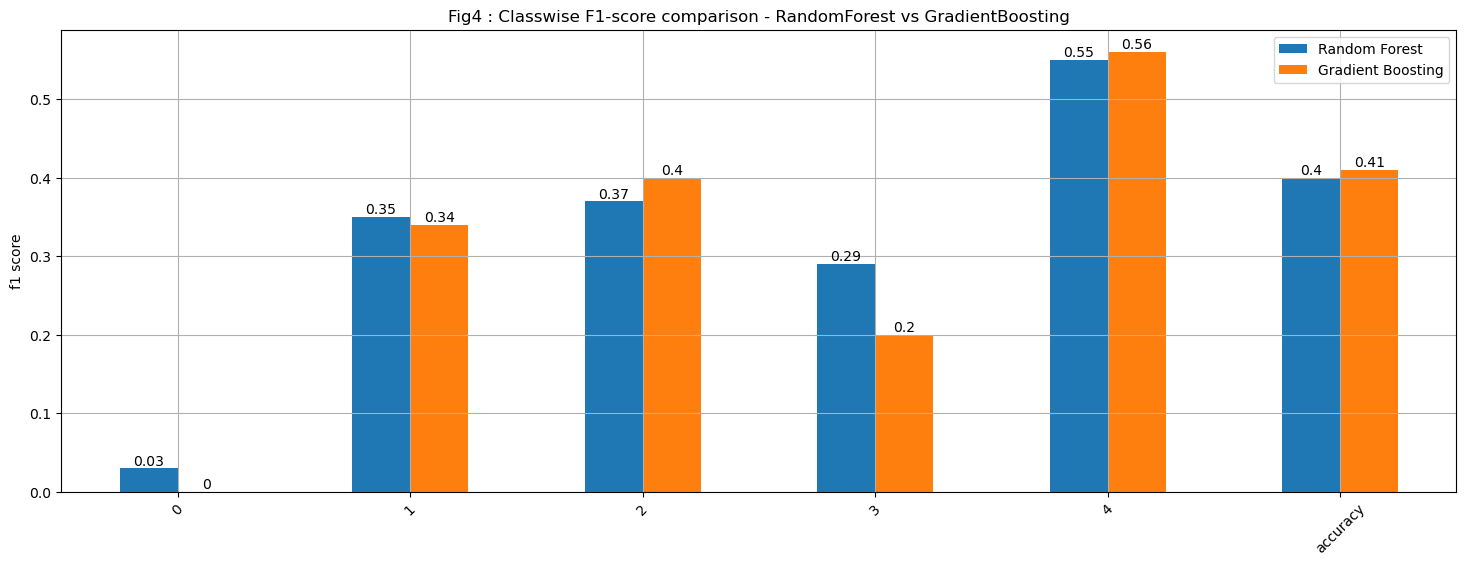

In [73]:
#Capture F1-score/class for comparision before and after SMOTE
config.rnforest_f1report = cf.get_classification_report(dsholder2, pipelinefactory.rnforest)
config.gbc_f1report = cf.get_classification_report(dsholder2, pipelinefactory.gbc)
config.xgb_f1report = cf.get_classification_report(dsholder2, pipelinefactory.xgb)

X_train, X_test, y_train, y_test = dsholder2.get()
target_classes = np.sort(y_train.unique())

#Capture class details 
config.rnforest_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.rnforest.predict(X_test), labels=target_classes)))
config.gbc_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.gbc.predict(X_test), labels=target_classes)))
config.xgb_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.xgb.predict(X_test), labels=target_classes)))

#### F1-score  Comparison
model = 'RandomForest vs GradientBoosting'
dfs = [config.rnforest_f1report, config.gbc_f1report]
legends=['Random Forest', 'Gradient Boosting']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, f'{model}', config)


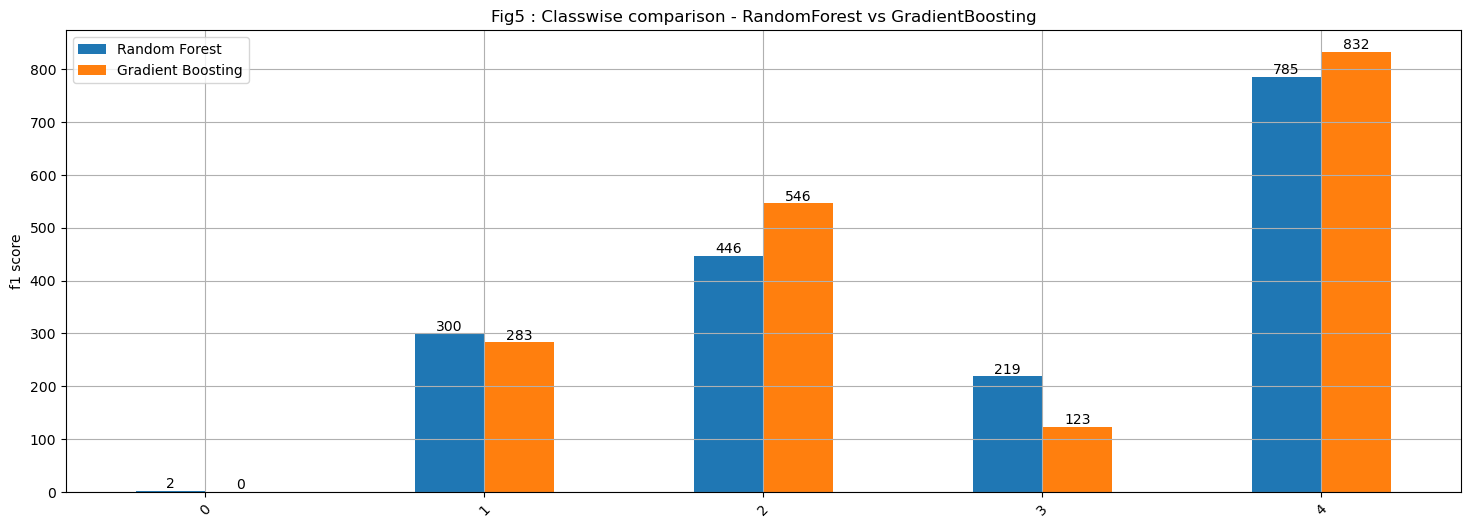

In [74]:
# Show classwise comparison of accurately predicted classes
cf.show_classdata_comparison([config.rnforest_classes_arr, config.gbc_classes_arr], target_classes, ['Random Forest', 'Gradient Boosting'], model, config)


#### Observation for Classifiers comparison Random vs Gradient Boosting
* Scores are pretty comparable for both models, with Gradient Boosting performing slightly better by 1%
* The Class 0 of the target variable(AdoptionSpeec) is very interesting, which represents First day adoption
    * For GradientBoosting it is 0 - So nothing
    * For Random Forest it is 1
    * The ROC curve for Class0 shows almost perfect area of 0.64 which does equate to data from ConfusionMatix.
* Class 1,2 and 4 Gradient Boosting performs better
* Class 3 Random Forest performs better

Test scores are betterthat the baseline model of LogisticRegresion, let's see we can improve it by using SMOTE and balancing the classes


#### SMOTE Test
- Will perform SMOTE across various algorithms and select the one with the best scores
    - SMOTE
    - ADASYN
    - BoderLineSMOTE
 

In [77]:
from imblearn.over_sampling import (
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
)

oversampler_dict = {
    'SMOTE': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5),
    'ADASYN': ADASYN(
        sampling_strategy='minority',
        random_state=0,
        n_neighbors=5),
    'BORDER': BorderlineSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1')
}


In [78]:
# Usual Data prep stuff
dfs =[]
X_train, X_test, y_train, y_test = dsholder2.get()
processor_config = config
processor_config.init_globals()
preprocessor = cf.getPreprocessor(processor_config)
processor_config.preprocessor = preprocessor
config.preprocessor = preprocessor

if(processor_config.globalloglevel == 2 ):
    print(processor_config.categorical_features)
    print(processor_config.numerical_features)
    print(processor_config.preprocessor)
    print(processor_config.scorer)


for oversampler in oversampler_dict.keys():
    print(f'****************** {oversampler} ****************************')
    # resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    dsholder2_1 = cf.DatasetHolder()
    dsholder2_1.update(X_resampled, X_test, y_resampled, y_test)
    pipelinefactory = cf.PipelineFactory(processor_config.preprocessor)
    # Run pipelines and collect data
    processor_config = cf.run_pipelines(pipelinefactory, dsholder2_1, processor_config, True)
    # Dump the results of tuned classifier comparison
    temo_df = cf.dump_df(processor_config)
    temo_df = temo_df.set_index('Model')
    temo_df.drop(['Best Params','Train Time','Train Accuracy', 'Test MSE'], axis=1, inplace=True)
    temo_df.rename(columns={'Test Accuracy': f'{oversampler}'}, inplace=True)
    dfs.append(temo_df)


****************** SMOTE ****************************
=========== Executing - Logistic Regression ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.35660649819494583, Test Score=0.303023309485345, Mean_fit_time=0.22406249046325682
{'classifier__class_weight': 'balanced'}
=========== Executing - Multi Logistic Regression ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.35898916967509026, Test Score=0.3009462266328179, Mean_fit_time=0.1835488796234131
{}
=========== Executing - KNN ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.5924909747292418, Test Score=0.2607892914839603, Mean_fit_time=0.04003305435180664
{}
=========== Executing - Decision Tree ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.6706859205776173, Test Score=0.3164089545349642, Mean_fit_time=0.23076157569885253
{'classifier__class_weight': 'balanced'}
======

In [79]:
#### SMOTE  Comparison
combined_df = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)
combined_df = pd.merge(combined_df, dfs[2], left_index=True, right_index=True)
result_df_without_smote = results_df.copy()
result_df_without_smote.drop(['Best Params','Train Time','Train Accuracy', 'Test MSE'], axis=1, inplace=True)
result_df_without_smote.rename(columns={'Test Accuracy': 'Before SMOTE'}, inplace=True)
combined_df_smote = pd.merge(combined_df, result_df_without_smote, how='left', left_index=True, right_index=True)
combined_df_smote

SMOTE    ADASYN    BORDER  Before SMOTE
Model                                                                
Logistic Regression        0.303023  0.297023  0.300254      0.316409
Multi Logistic Regression  0.300946  0.301639  0.296561      0.357027
KNN                        0.260789  0.262405  0.273252      0.310408
Decision Tree              0.316409  0.309716  0.330487      0.308331
Random Forest              0.383568  0.382414  0.383568      0.404339
Gradient Boosting          0.393030  0.394415  0.390492      0.411724

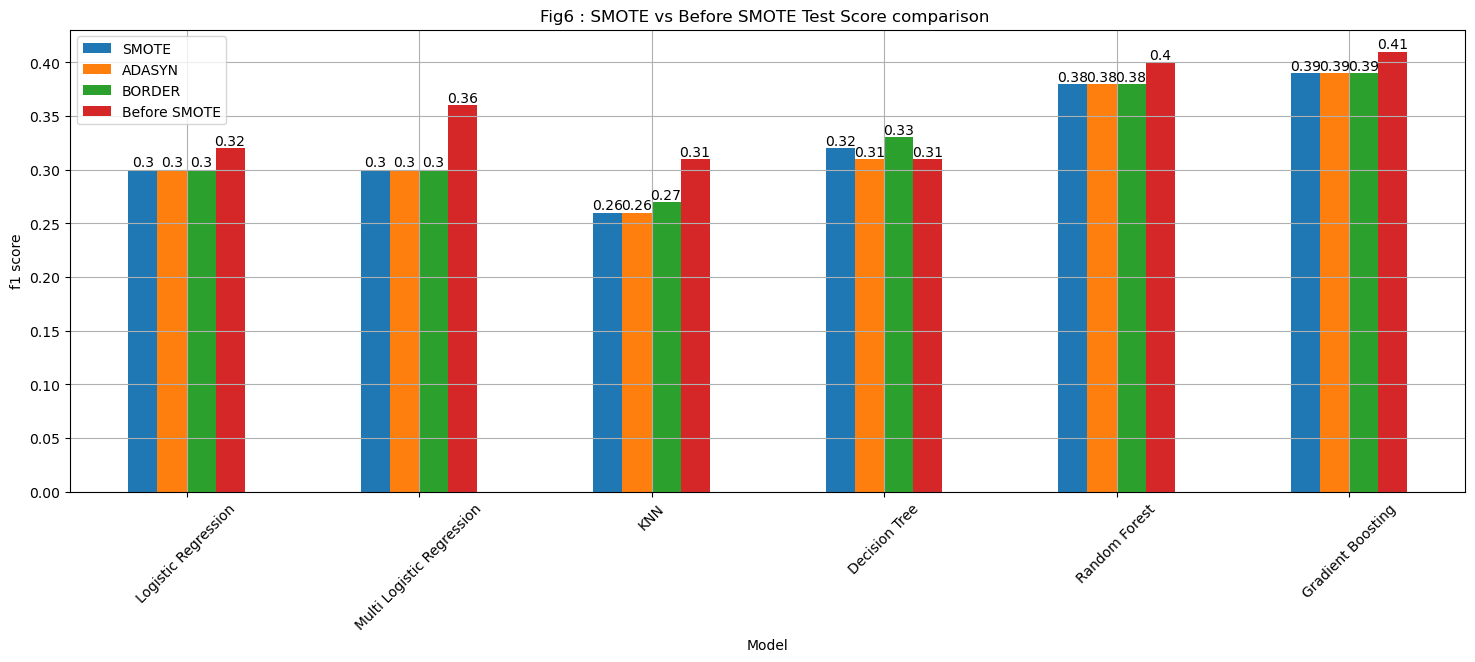

In [80]:
figcounter = cf.cust_bar_plot(combined_df_smote, f'SMOTE vs Before SMOTE Test Score comparison ', 
              config, 'smote_comparison.png')

#### Observations
- SMOTE has not helped improve the f1-score for most of the classifiers
- RandomForest score has is almost similar with BorderLine from 0.40 to 0.39
- Decision Tree shows a 1% improvement
- No reason to use SMOTE data going forward, but lets perform a comparison of the stats, to see if SMOTE technique helps in class-wise predictions. WIll run the following classifier for comparison
    - RandomForest
    - XGBoost
    - GradientBoosting 

In [82]:
# BORDER has the closest results, very close to NON-SMOTE, let use that approach to look at stats
# for Random Forest and Gradient Boosting

X_train, X_test, y_train, y_test = dsholder2.get()
X_resampled, y_resampled = oversampler_dict.get('BORDER').fit_resample(X_train, y_train)
dsholder3 = cf.DatasetHolder()
dsholder3.update(X_resampled, X_test, y_resampled, y_test)


dummy_params = {}
# Rest the variables to new set of dataset using SMOTE data
X_train, X_test, y_train, y_test = dsholder3.get()

config.init_globals()
config.scoring_metric = 'f1'
config.scorer = cf.get_custom_scorer(config.scoring_metric, 'micro')
pipelinefactory = cf.PipelineFactory(config.preprocessor)

pipelinefactory.rnforest = cf.perform_test(GridSearchCV(pipelinefactory.rnforest, param_grid=default_params, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Random Forest', config, dsholder3)
pipelinefactory.gbc = cf.perform_test(GridSearchCV(pipelinefactory.gbc, param_grid={}, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Gradient Boosting', config, dsholder3)
pipelinefactory.xgb = cf.perform_test(GridSearchCV(pipelinefactory.xgb, param_grid={}, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'XGBoost', config, dsholder3)


=========== Executing - Random Forest ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.8179061371841155, Test Score=0.3835679667666744, Mean_fit_time=1.908388376235962
{'classifier__class_weight': 'balanced'}
=========== Executing - Gradient Boosting ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.5129963898916967, Test Score=0.39049157627509806, Mean_fit_time=11.294003772735596
{}
=========== Executing - XGBoost ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.6693862815884477, Test Score=0.38818370643895683, Mean_fit_time=0.539229154586792
{}


Classification Report - SMOTE Data-Random Forest-f1
              precision    recall  f1-score   support

           0       0.08      0.10      0.09       125
           1       0.33      0.39      0.36       906
           2       0.35      0.27      0.31      1159
           3       0.32      0.29      0.31       886
           4       0.52      0.57      0.54      1257

    accuracy                           0.38      4333
   macro avg       0.32      0.33      0.32      4333
weighted avg       0.38      0.38      0.38      4333



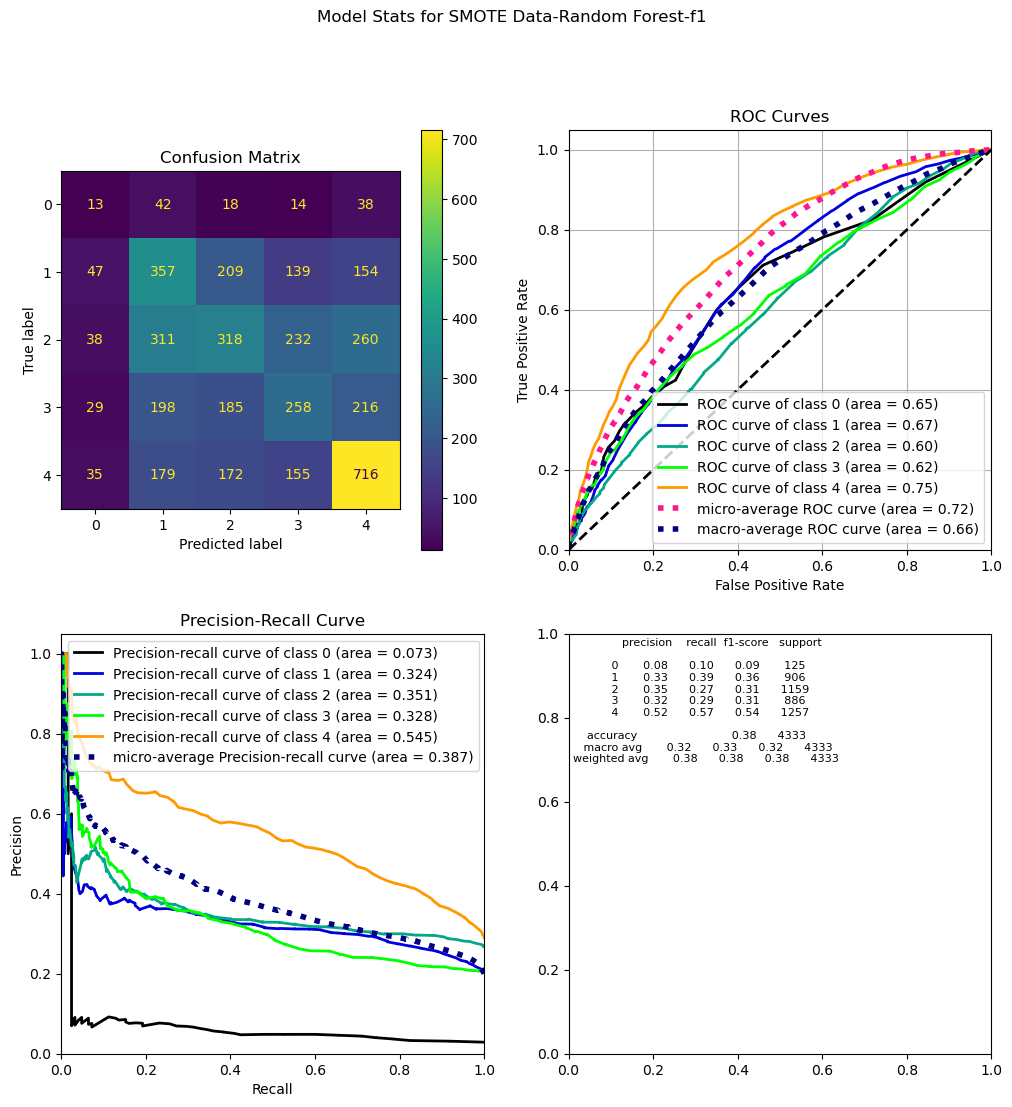

In [83]:
#Capture class details for Rnforest and XGB

config.rnforest_f1report_smote = cf.get_classification_report(dsholder3, pipelinefactory.rnforest)
config.xgb_f1report_smote = cf.get_classification_report(dsholder3, pipelinefactory.xgb)
config.rnforest_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.rnforest.predict(X_test), labels=target_classes)))
config.xgb_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.xgb.predict(X_test), labels=target_classes)))

#Let's look at the stats for Random Forest, so as to compare with original dataset results
cf.show_logistic_model_stats(dsholder3, pipelinefactory.rnforest,  
                             f'SMOTE Data-Random Forest-{scoring_metric}', config)


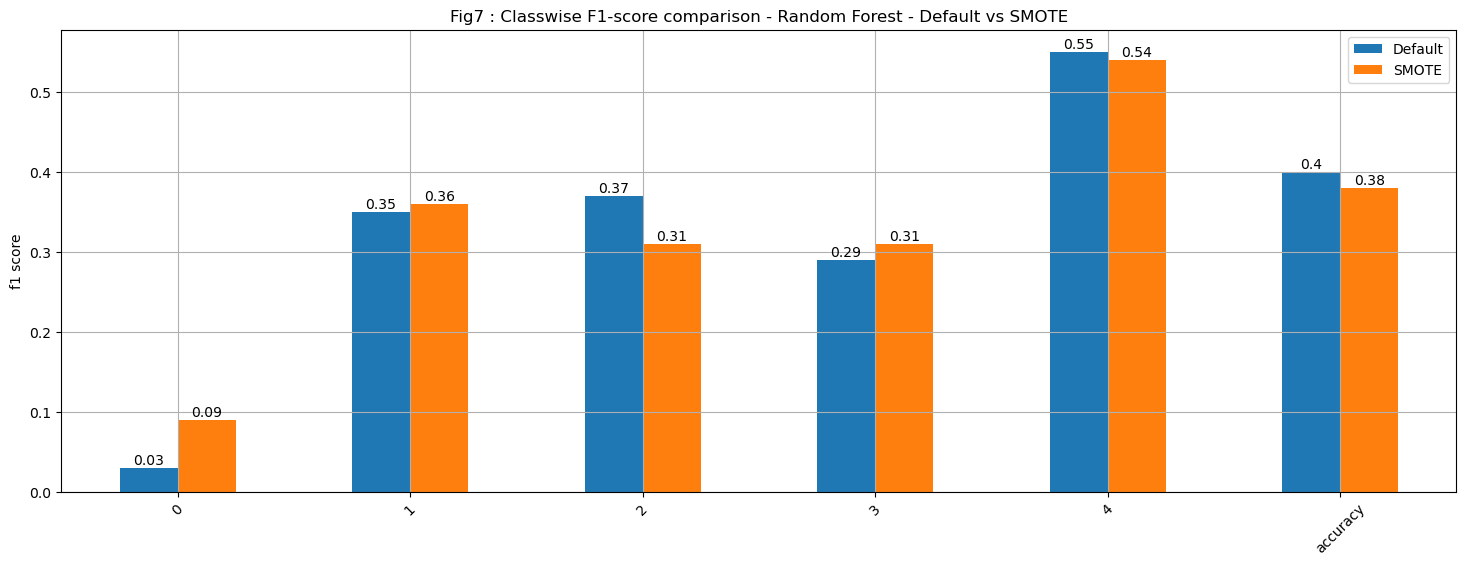

In [84]:
# Plot RandomForest f1-score difference between default and SMOTE
dfs = [config.rnforest_f1report, config.rnforest_f1report_smote]
legends=['Default', 'SMOTE']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, 'Random Forest - Default vs SMOTE', config)


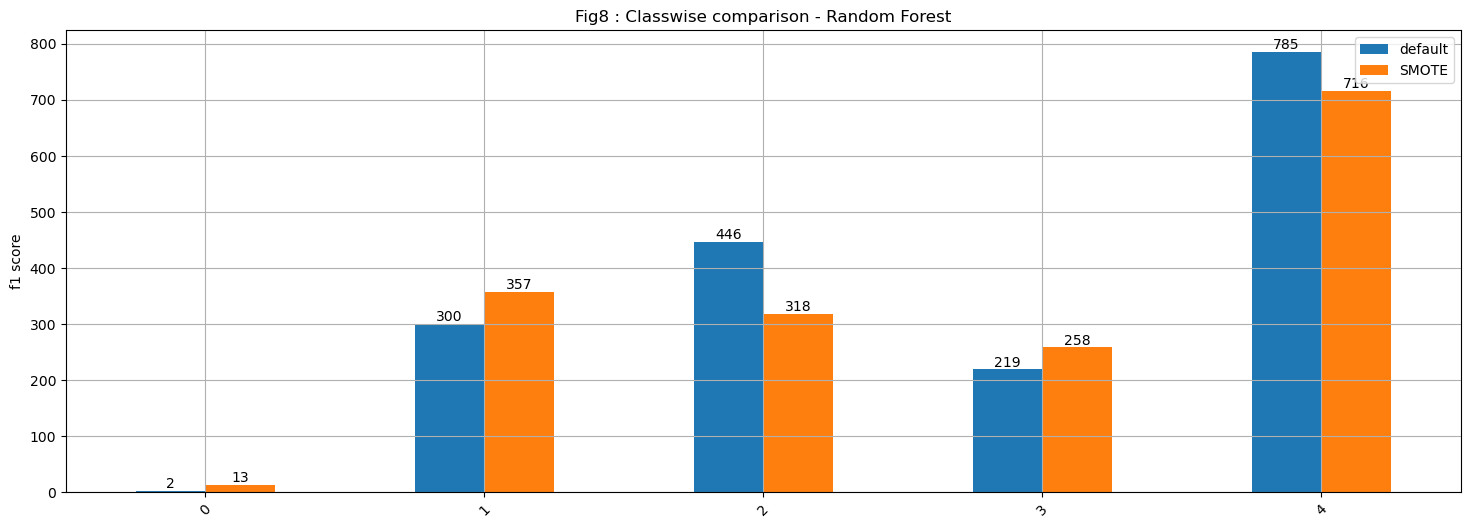

In [85]:
# Class numbers correctly identified in Random Forest
cf.show_classdata_comparison(config.rnforest_classes_arr, target_classes, ['default', 'SMOTE'],  'Random Forest', config)

#### Observations -  RandomForest
- The overall f1-score is not affected, maybe slighly reduced from 40% to 39%
- Class f1-scores
    - Class 0,1 and 3 has improved with 0 having a significant jump
    - Class 2 it has decreased
    - Class 4 is same
- Class-wise actual predictions from ConfusionMatrix
    - Class 0 has improved from 1 to 16
    - Class 1 sees a bug jump from 270 to 357
    - Class 2 sees a similar drop from 459 to 344
    - Class 3 has slightly increased and Class 4 has decreased.
      
It is plus minus either side, hence the average f1-score is same   

Classification Report - SMOTE data-Gradient Boosting-f1
              precision    recall  f1-score   support

           0       0.09      0.13      0.10       125
           1       0.33      0.37      0.35       906
           2       0.36      0.28      0.32      1159
           3       0.34      0.25      0.29       886
           4       0.50      0.62      0.55      1257

    accuracy                           0.39      4333
   macro avg       0.32      0.33      0.32      4333
weighted avg       0.38      0.39      0.38      4333



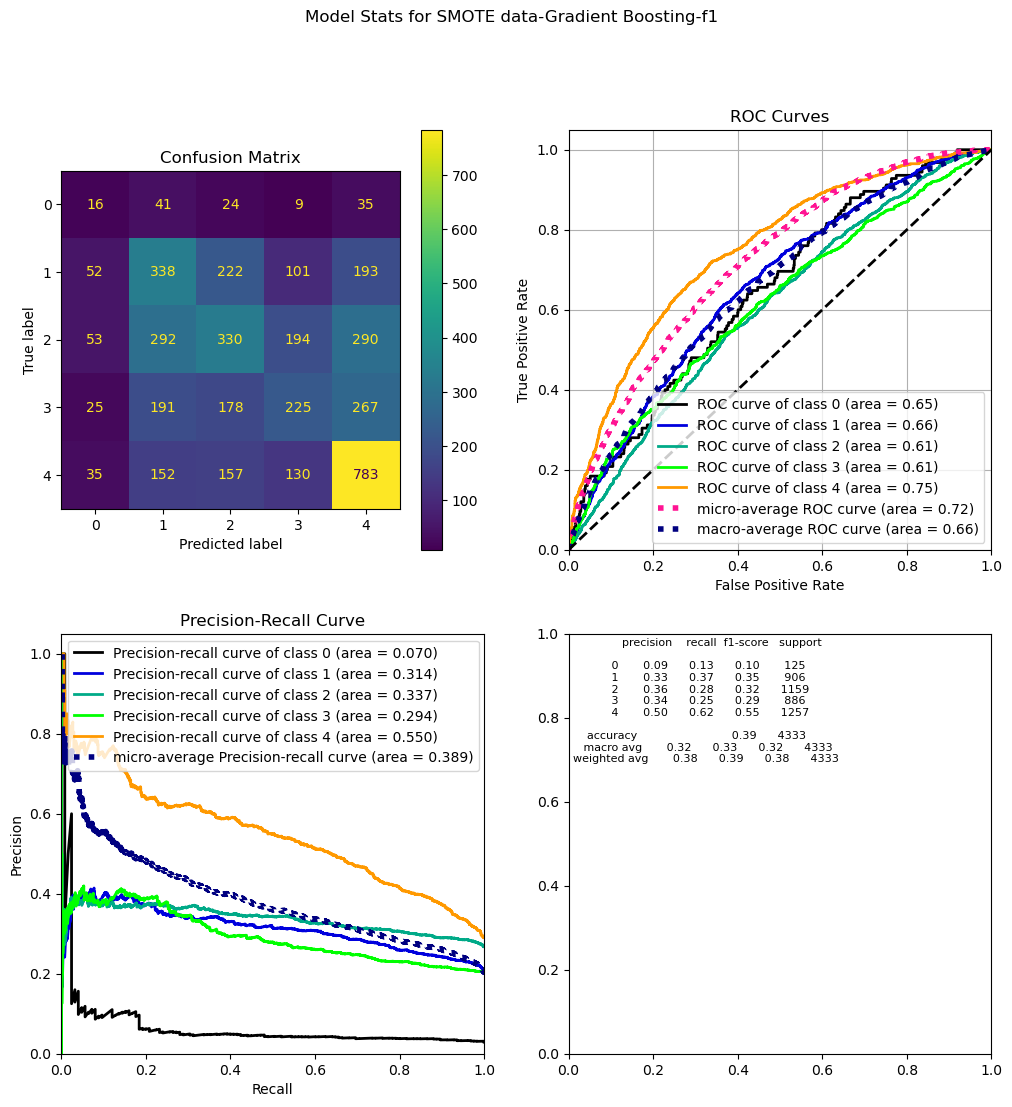

In [87]:
# Capture stats for Gradient Boosting
config.gbc_f1report_smote = cf.get_classification_report(dsholder3, pipelinefactory.gbc)
config.gbc_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.gbc.predict(X_test), labels=target_classes)))

#Let's look at the stats for Gradient Boosting, so as to compare with original dataset results
cf.show_logistic_model_stats(dsholder3, pipelinefactory.gbc,  f'SMOTE data-Gradient Boosting-{scoring_metric}', config)


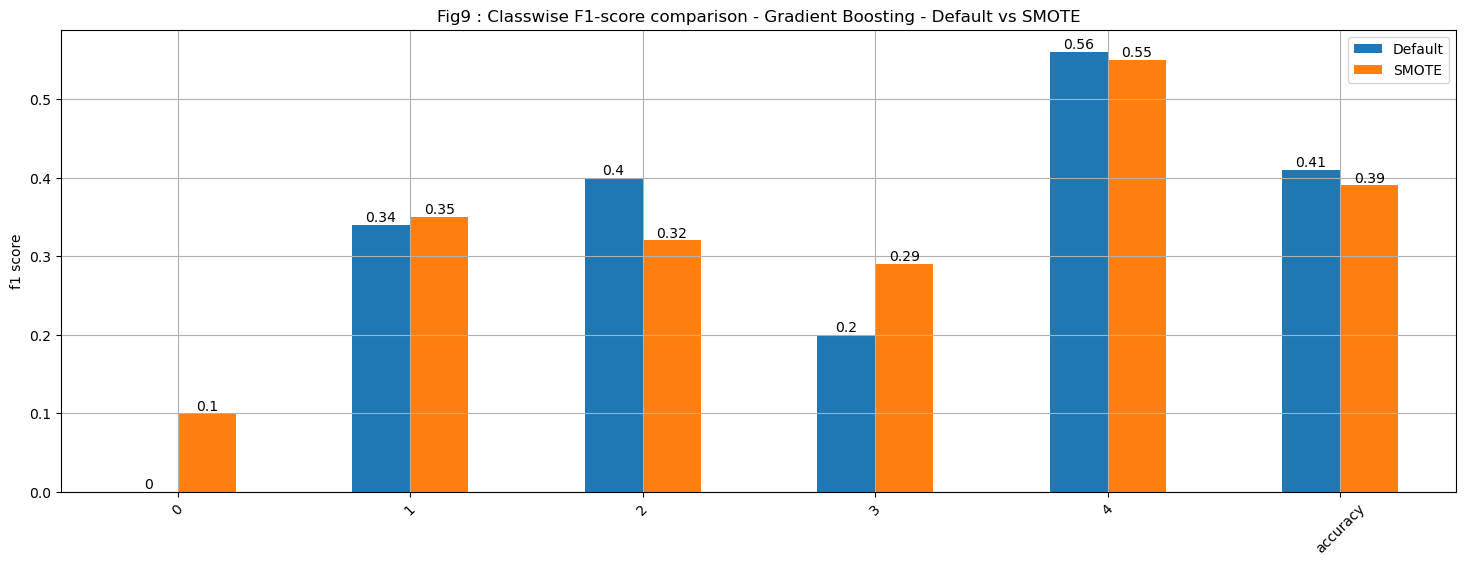

In [88]:
# Plot GradientBoosting f1-score difference between default and SMOTE
dfs = [config.gbc_f1report, config.gbc_f1report_smote]
legends=['Default', 'SMOTE']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, 'Gradient Boosting - Default vs SMOTE', config)


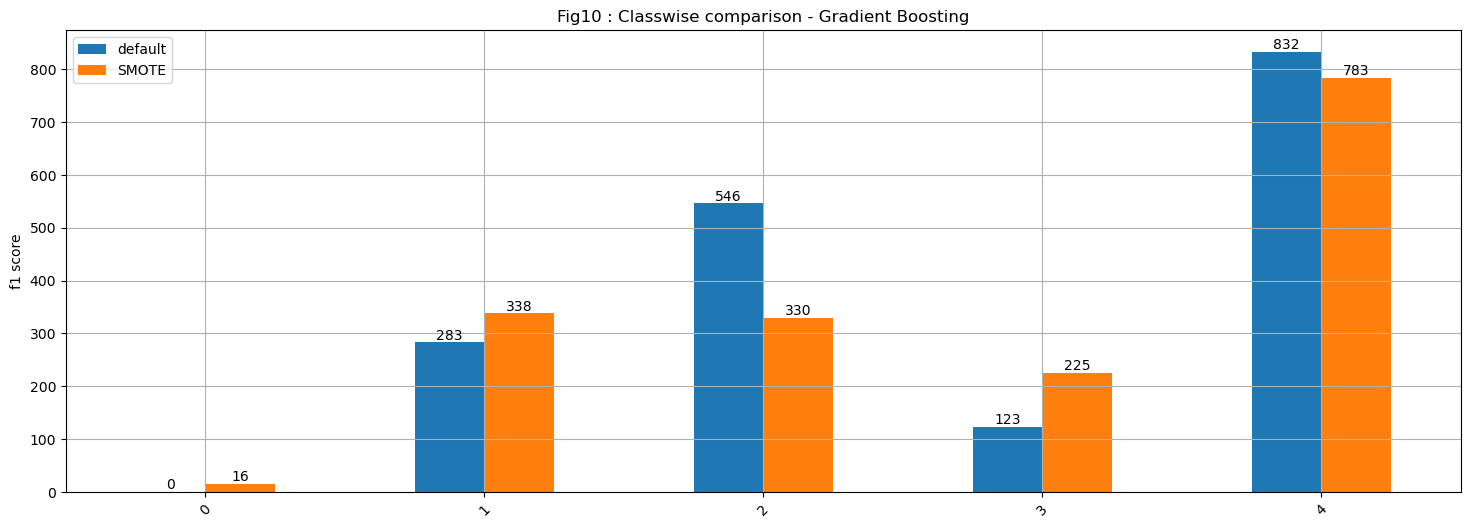

In [89]:
# Class numbers correctly identified in Gradient Boosting
cf.show_classdata_comparison(config.gbc_classes_arr, target_classes, ['default', 'SMOTE'],  'Gradient Boosting', config)

#### Observations -  Gradient Boosting
- The overall f1-score has slighly reduced from 41% to 39%
- Class f1-scores
    - Class 0,1 and 3 has improved with 0 having a significant jump
    - Class 2 it has decreased
    - Class 4 is same
- Class-wise actual predictions from ConfusionMatrix
    - Class 0 has improved from 0 to 16
    - Class 1 sees a bug jump from 283 to 338
    - Class 2 sees a significant drop from 548 to 336
    - Class 3 has increased and Class 4 has decreased
It is plus minus either side, hence the average f1-score is same. The observation were similar to the RandomForest    

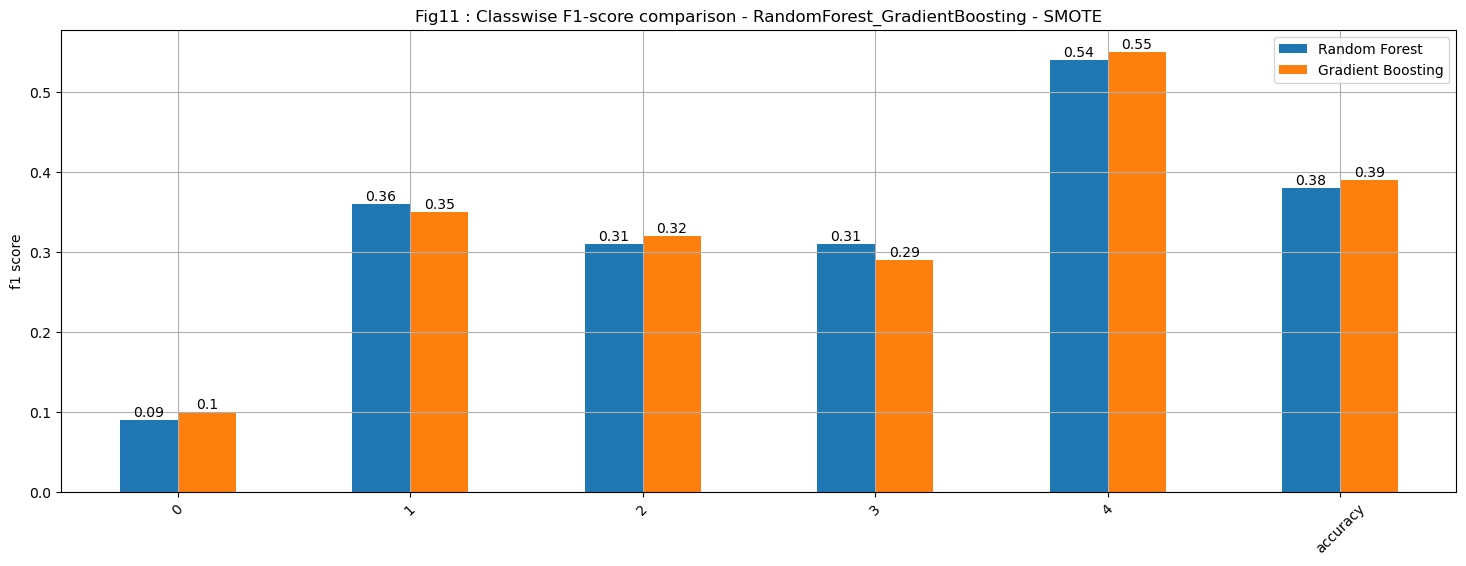

In [91]:
#Capture F1-score/class for comparision Random Forest vs Gradient Boosting after SMOTE
model = 'RandomForest_GradientBoosting'

# Plot GradientBoosting f1-score difference between default and SMOTE
dfs = [config.rnforest_f1report_smote, config.gbc_f1report_smote]
legends=['Random Forest', 'Gradient Boosting']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, f'{model} - SMOTE', config)


#### Observations RandomForest vs GradientBoosting
- Pretty much similar across the board, with very small differences between each classes.

##### SMOTE may not helped in the overall score, but we see it has helped in Class 0 predictions, so we can use the SMOTE dataset going forward  

In [93]:
dsholder4 = dsholder3
X_train, X_test, y_train, y_test = dsholder4.get()


## Tuning the Top Models  
  
Now that we 3 top models RandomForest, GradientBoosting and XGBoost, will tune to see if we can improve f1-score

- Hyperparameter tuning
- Threshold tuning

In [95]:
config.init_globals()
config.scoring_metric = 'f1'
config.globalloglevel=2
config.scorer = cf.get_custom_scorer(config.scoring_metric, 'micro')

# Create a preprocessor object with TargetEncoder
preprocessor = cf.getPreprocessor(config)

# Create pipeline factory again
pipelinefactory = cf.PipelineFactory(preprocessor)



#### Random Forest Tuning

In [97]:
# Hypertuning all parameters took hours run only publishing the tuned parameter set
rnforest_params3 = {
        'classifier__n_estimators' : [3000],
        'classifier__max_features' : [None],
        'classifier__max_depth' : [25],
        'classifier__class_weight' : ['balanced_subsample'],
        'classifier__max_samples': [0.3],
        }


=========== Executing - Random Forest ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=25, classifier__max_features=None, classifier__max_samples=0.3, classifier__n_estimators=3000; total time= 2.2min
[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=25, classifier__max_features=None, classifier__max_samples=0.3, classifier__n_estimators=3000; total time= 2.1min
[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=25, classifier__max_features=None, classifier__max_samples=0.3, classifier__n_estimators=3000; total time= 2.1min
[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=25, classifier__max_features=None, classifier__max_samples=0.3, classifier__n_estimators=3000; total time= 2.1min
[CV] END classifier__class_weight=balanced_subsample, classifier__max_depth=25, classifier__max_features=None, classifier__max

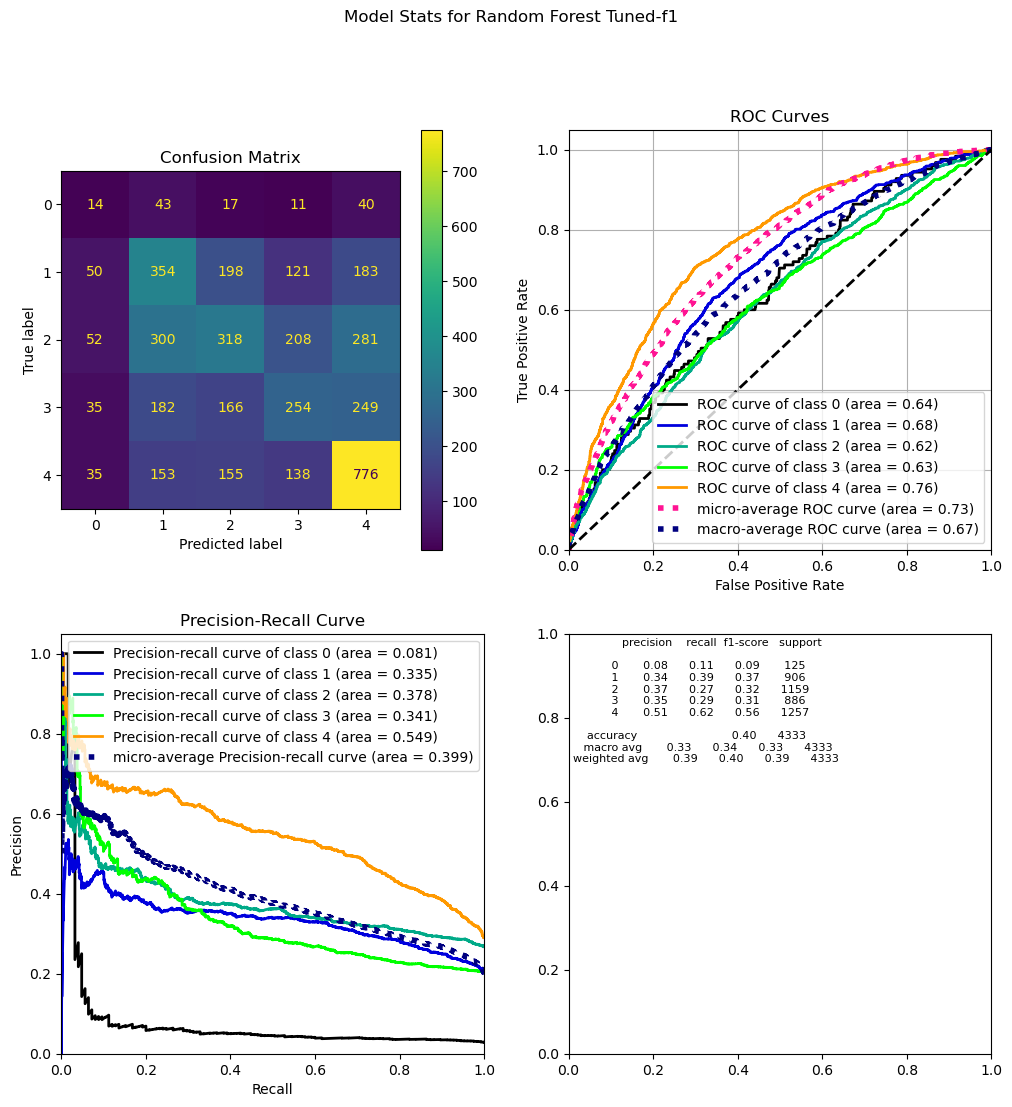

In [98]:
# Run the Random Forest Pipeline
pipelinefactory.rnforest = cf.perform_test(GridSearchCV(pipelinefactory.rnforest, param_grid=rnforest_params3, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  'Random Forest', config, dsholder4)

# Capture the classification report data
config.rnforest_f1report_tuned = cf.get_classification_report(dsholder4, pipelinefactory.rnforest)

# Show the model stata
cf.show_logistic_model_stats(dsholder4, pipelinefactory.rnforest,  f'Random Forest Tuned-{scoring_metric}', config)


In [99]:
#Capture class details 
config.rnforest_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.rnforest.predict(X_test), labels=target_classes)))

In [100]:
#Capture Class Data for tuned RNForest 
tuner = tt.ClassificationThresholdTuner()

# Tune the model with thresholds 
rn_tuned_pred_int = cf.get_tuned_predictions(tuner, 'Random Forest', pipelinefactory.rnforest, dsholder4, config) 

 40%|██████████████████                           | 2/5 [00:17<00:26,  8.95s/it]


Random Forest -  [0.30000000000000004, 0.2, 0.2, 0.298999, 0.0]


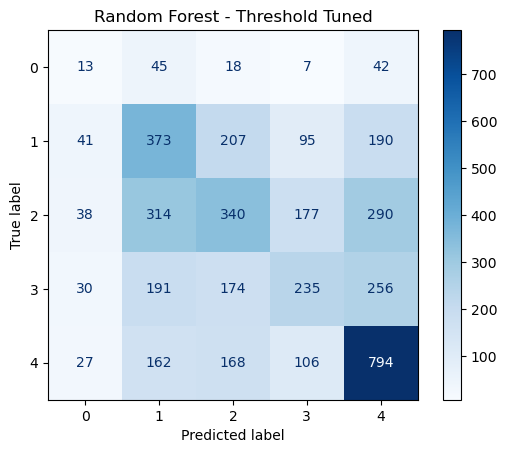

In [101]:
#Show Confusion Matrix for threshold tuned
disp = ConfusionMatrixDisplay.from_predictions(y_test, rn_tuned_pred_int, cmap=plt.cm.Blues);
disp.ax_.set_title('Random Forest - Threshold Tuned');

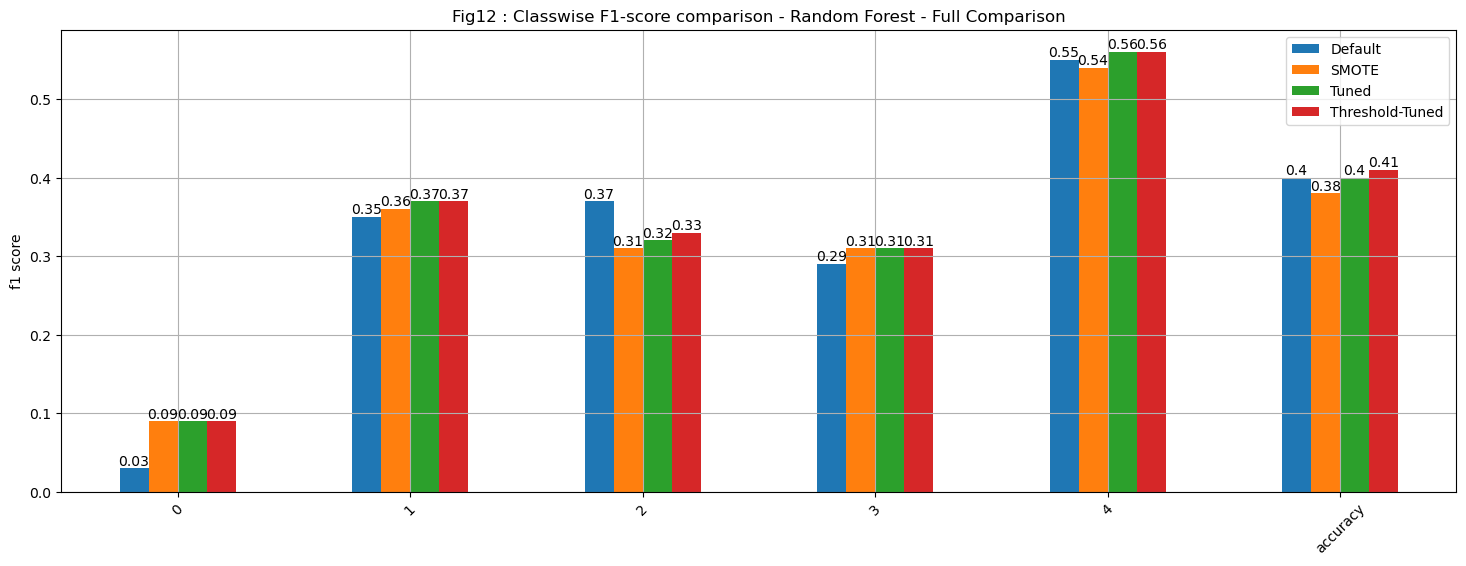

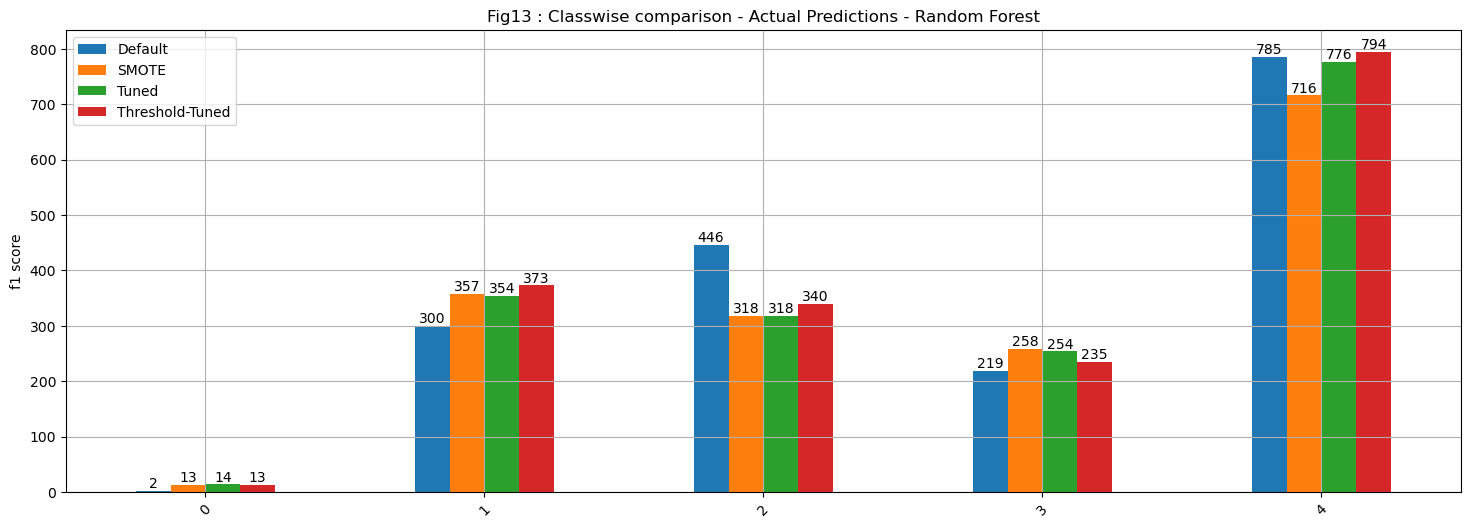

In [102]:
config.rnforest_f1report_tuned_threshold = cf.get_classification_report(dsholder4, pipelinefactory.rnforest, y_preds=rn_tuned_pred_int)

# Plot Random Forest f1-score difference across all tests
dfs = [config.rnforest_f1report, config.rnforest_f1report_smote, config.rnforest_f1report_tuned, config.rnforest_f1report_tuned_threshold]
legends=['Default', 'SMOTE', 'Tuned', 'Threshold-Tuned']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, 'Random Forest - Full Comparison', config)

#Capture class details 
config.rnforest_classes_arr.append(np.diagonal(confusion_matrix(y_test, rn_tuned_pred_int, labels=target_classes)))

# Plot the Class-wise prediction comparison across all tests
cf.show_classdata_comparison(config.rnforest_classes_arr, target_classes, legends,  'Actual Predictions - Random Forest', config)


#### Observations -  RandomForest(default  vs  SMOTE  vs  HyperTune  vs HyperTun + ThresholdTunes)
- The overall f1-score was not impacted via hypertuning, but threshold tuning brought the score up from 39% to 40%
- Class f1-scores 
    - Class 1 and 3 improve by 1%
    - Clas 2 is the only we see decrease in score by 4% 
- Class-wise actual predictions from ConfusionMatrix
    - Class 0 has improved from 1 to 13
    - Class 1 sees a bug jump from 270 to 371
    - Class 2 sees a similar drop from 459 to 340
    - Class 3 and 4 has slightly increased
      
The f1-score may not show significant improvement, but classwise predictions have improved. Even from confusion matrix the diagonal with actual predictions are maximum numbers in all classes, apart from Class0. So definately see a decent improvement  

#### XGBoostClassifier Tuning

In [105]:
# Hyperparameters after tuning
xgb_params = {
        'classifier__max_depth' : [13],
        'classifier__gamma': [0.3],
        'classifier__subsample': [0.8],
        'classifier__colsample_bytree': [0.8],
        'classifier__learning_rate': [0.01],
        'classifier__n_estimators': [1500],
        'classifier__min_child_weight': [1],
}
model = 'XGBoost'

=========== Executing - XGBoost ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train Score=0.8182671480144404, Test Score=0.4011077775213478, Mean_fit_time=34.03323907852173
{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.3, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 13, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 1500, 'classifier__subsample': 0.8}
Classification Report - XGBoost-f1
              precision    recall  f1-score   support

           0       0.14      0.06      0.08       125
           1       0.34      0.35      0.35       906
           2       0.34      0.32      0.33      1159
           3       0.36      0.32      0.34       886
           4       0.52      0.61      0.56      1257

    accuracy                           0.40      4333
   macro avg       0.34      0.33      0.33      4333
weighted avg       0.39      0.40      0.39      4333



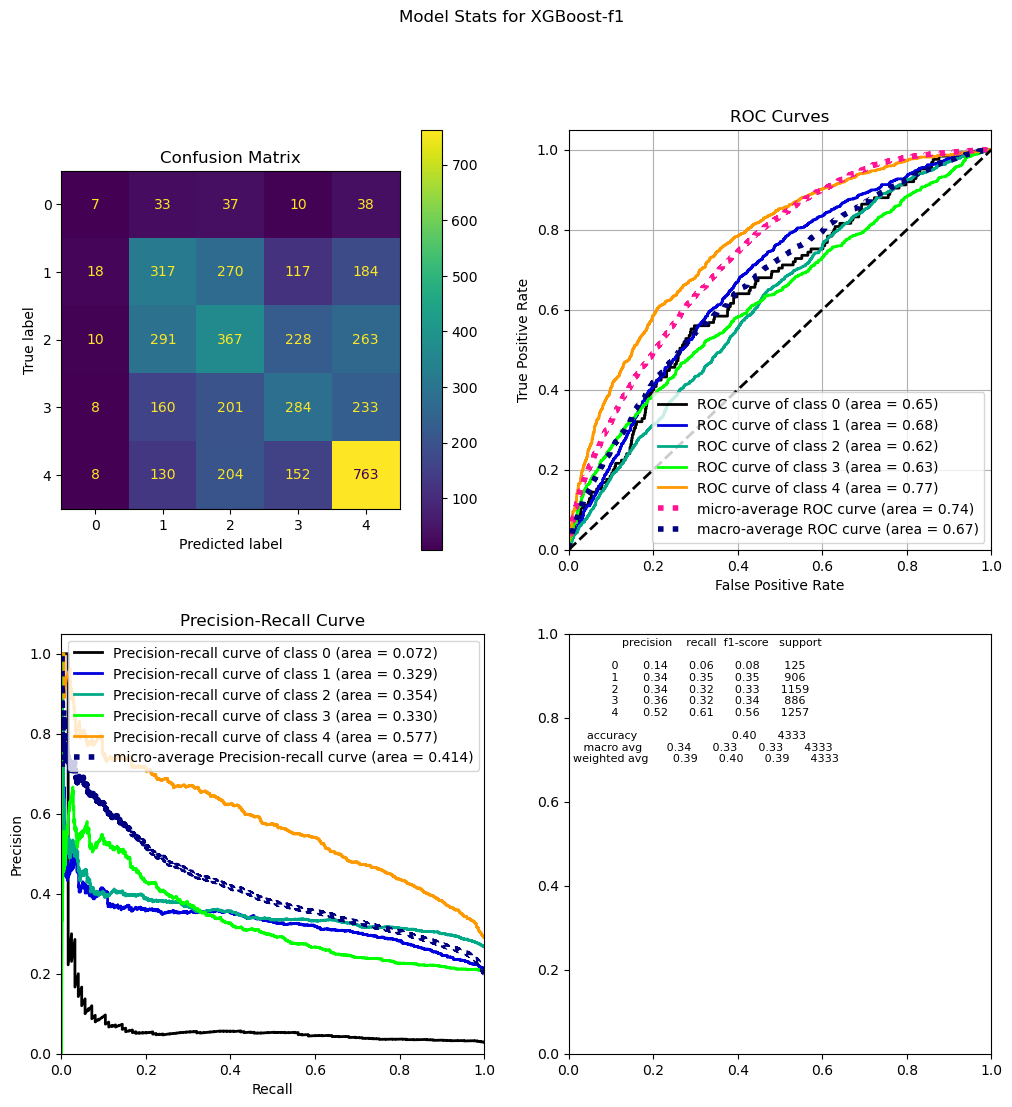

In [106]:
# Run the XGBoost pipleline
pipelinefactory.xgb = cf.perform_test(GridSearchCV(pipelinefactory.xgb, param_grid=xgb_params, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise', n_jobs=4),  model, config, dsholder4)

# Capture classification comparison
config.xgb_f1report_tuned = cf.get_classification_report(dsholder4, pipelinefactory.xgb)

# Plot model stats
cf.show_logistic_model_stats(dsholder4, pipelinefactory.xgb,  f'{model}-{scoring_metric}', config)


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]


XGBoost -  [0.30000000000000004, 0.19838, 0.2800000000000001, 0.30000000000000004, 0.0]


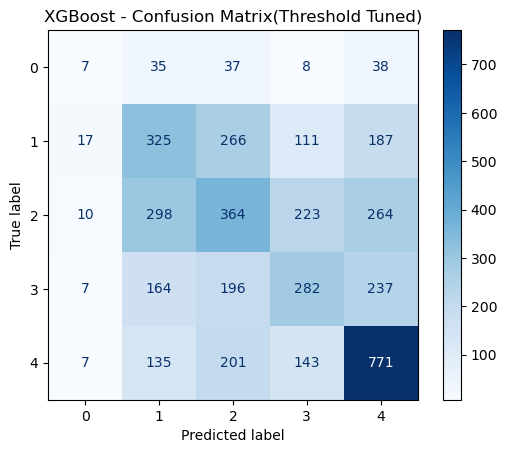

In [107]:
# Capture Class numbers from confusion matrix
config.xgb_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.xgb.predict(X_test), labels=target_classes)))

# Tune the model with thresholds 
xgb_tuned_pred_int = cf.get_tuned_predictions(tuner, model , pipelinefactory.xgb, dsholder4, config) 

#Show Confusion Matrix for threshold tuned
disp = ConfusionMatrixDisplay.from_predictions(y_test, xgb_tuned_pred_int, cmap=plt.cm.Blues);
disp.ax_.set_title(f'{model} - Confusion Matrix(Threshold Tuned)');


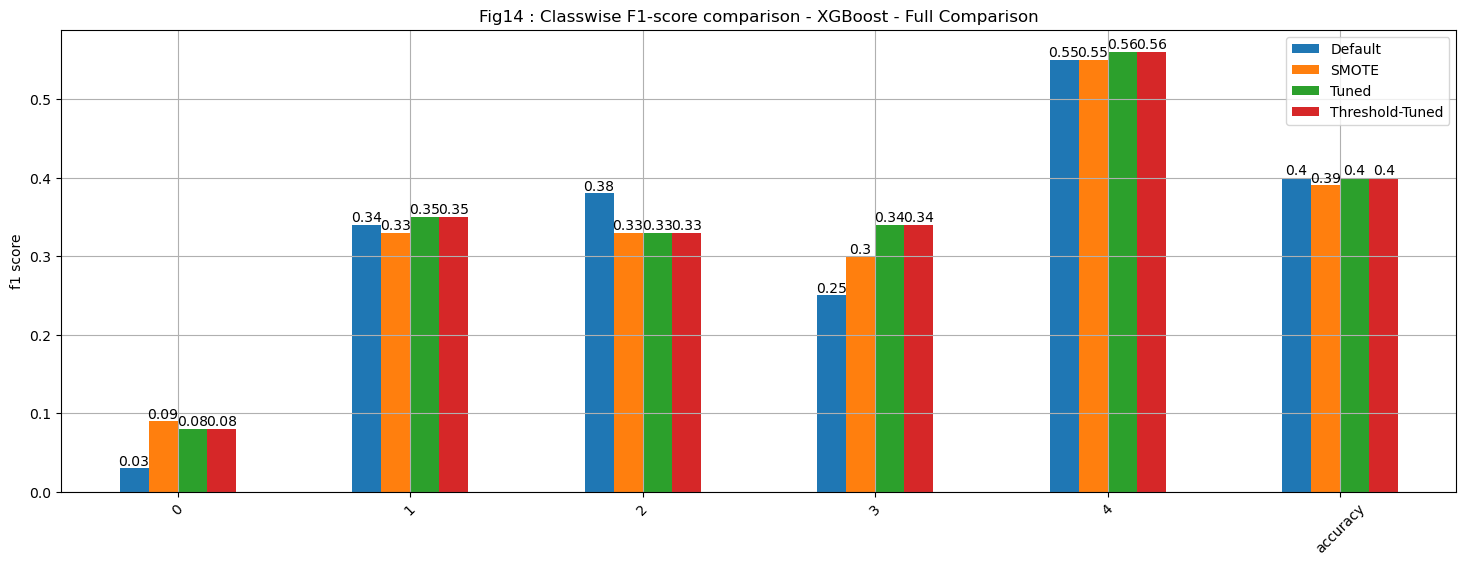

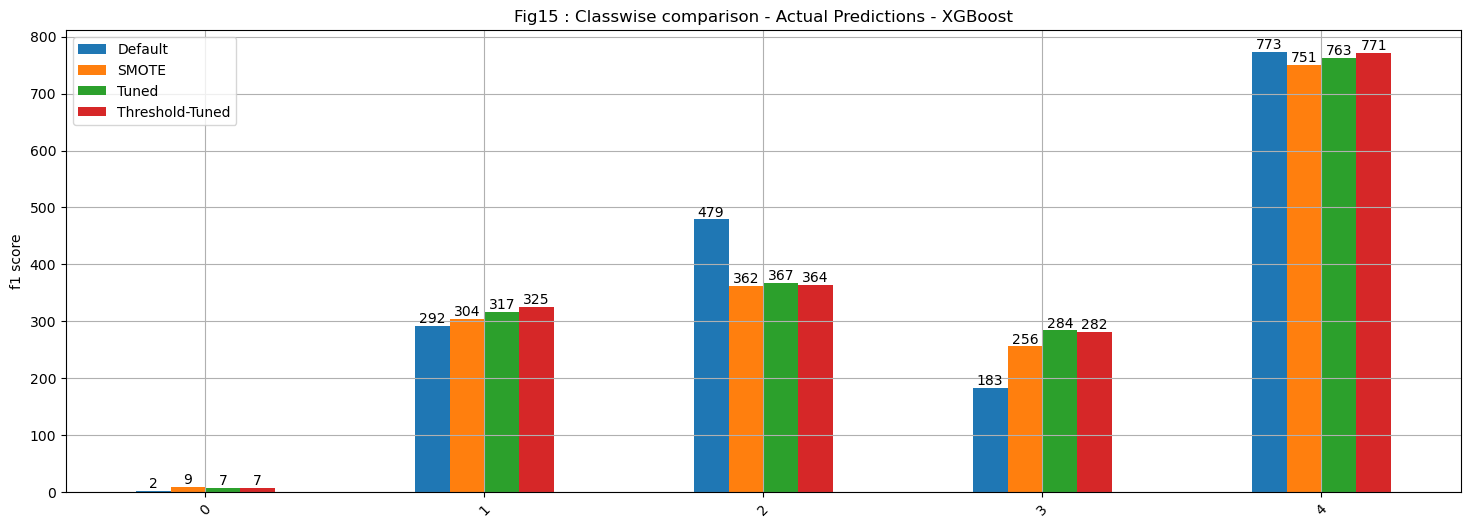

In [108]:
config.xgb_f1report_tuned_threshold = cf.get_classification_report(dsholder4, pipelinefactory.xgb, y_preds=xgb_tuned_pred_int)

# Plot XGBoost f1-score difference across all tests
dfs = [config.xgb_f1report, config.xgb_f1report_smote, config.xgb_f1report_tuned, config.xgb_f1report_tuned_threshold]
legends=['Default', 'SMOTE', 'Tuned', 'Threshold-Tuned']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, f'{model} - Full Comparison', config)

#Capture class details 
config.xgb_classes_arr.append(np.diagonal(confusion_matrix(y_test, xgb_tuned_pred_int, labels=target_classes)))

# Plot the Class-wise prediction comparison across all test
cf.show_classdata_comparison(config.xgb_classes_arr, target_classes, legends,  f'Actual Predictions - {model}', config)


#### Observations -  XGBoost(default  vs  SMOTE  vs  HyperTune  vs HyperTun + ThresholdTunes)
- The overall f1-score was not impacted via hypertuning, the score is comparable to default of 40%
- Class f1-scores 
    - Class 3 shows significant improvement from 28%(default) to 35%
    - Class 0 show improvement from 3%(default) to 9%
    - Clas 2 is the only we see decrease in score by 5% 
- Class-wise actual predictions from ConfusionMatrix
    - Class 0 has improved from 2(default) to 8
    - Class 1 sees a bug jump from 253 to 314
    - Class 2 sees a similar drop from 490 to 366
    - Class 3 and a slight improvement
    - Class 4 performance has reduces
      
The f1-score may not show significant improvement, but classwise predictions have improved. Even from confusion matrix the diagonal with actual predictions are maximum numbers in all classes, apart from Class0. So definately see a decent improvement  

#### GradientBoosting - Tuning

In [111]:
# Best Hyper params for the emodel
gbc_params2={
        'classifier__max_depth' : [13],
        'classifier__min_samples_split':[10],
        'classifier__learning_rate': [0.01],
        'classifier__n_estimators': [1500],
        'classifier__subsample': [0.8],
}
model = 'Gradient Boosting'

=========== Executing - Gradient Boosting ================
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=  11.3s
[CV] END .................................................... total time=  11.1s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  11.2s
[CV] END .................................................... total time=  10.6s
Train Score=0.5129963898916967, Test Score=0.39049157627509806, Mean_fit_time=10.99772276878357
{}
Classification Report - Gradient Boosting-f1
              precision    recall  f1-score   support

           0       0.09      0.13      0.10       125
           1       0.33      0.37      0.35       906
           2       0.36      0.28      0.32      1159
           3       0.34      0.25      0.29       886
           4       0.50      0.62      0.55      1257

    acc

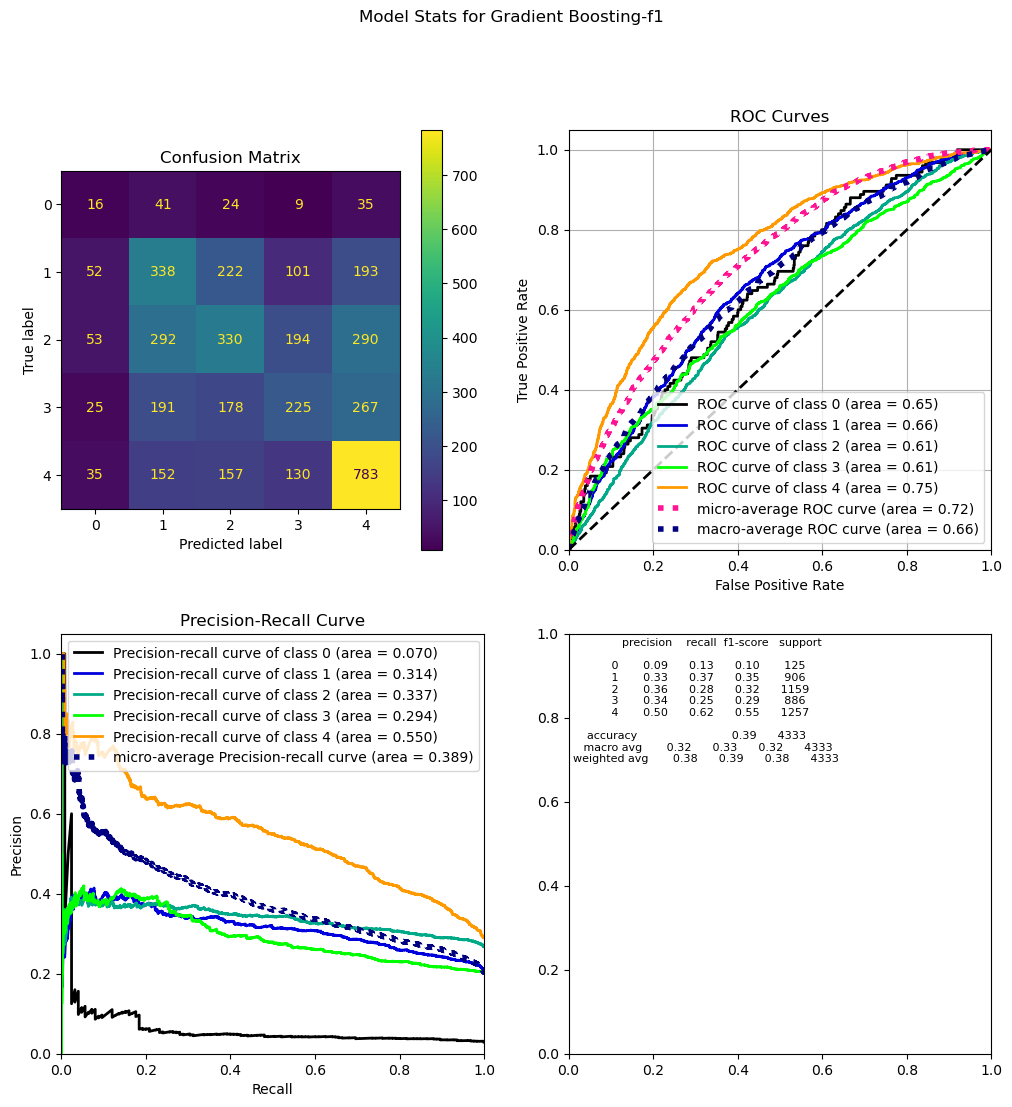

In [112]:
# Pipeline run for GradientBoosting model
pipelinefactory.gbc = cf.perform_test(GridSearchCV(pipelinefactory.gbc, param_grid={}, scoring=config.scorer, 
                                       verbose=config.globalloglevel, error_score='raise'),  model, config, dsholder4)
config.gbc_f1report_tuned = cf.get_classification_report(dsholder4, pipelinefactory.gbc)
cf.show_logistic_model_stats(dsholder4, pipelinefactory.gbc,  f'{model}-{scoring_metric}', config)


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.09s/it]


Gradient Boosting -  [0.02, 0.2, 0.2, 0.2, 0.0]


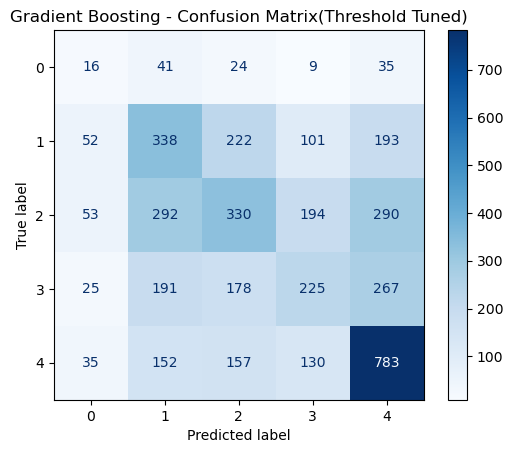

In [113]:
# Capture Class numbers from confusion matrix
config.gbc_classes_arr.append(np.diagonal(confusion_matrix(y_test, pipelinefactory.gbc.predict(X_test), labels=target_classes)))

# Tune the model with thresholds 
gbc_tuned_pred_int = cf.get_tuned_predictions(tuner, model, pipelinefactory.gbc, dsholder4, config) 

#Show Confusion Matrix for threshold tuned
disp = ConfusionMatrixDisplay.from_predictions(y_test, gbc_tuned_pred_int, cmap=plt.cm.Blues);
disp.ax_.set_title(f'{model} - Confusion Matrix(Threshold Tuned)');


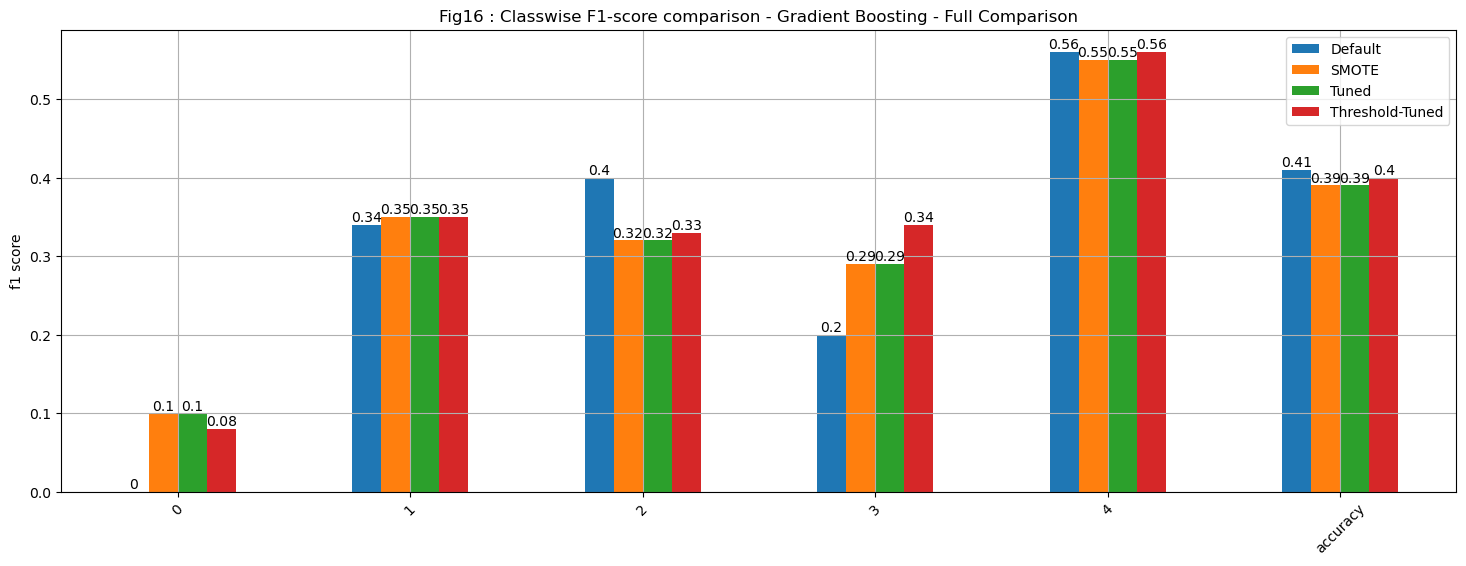

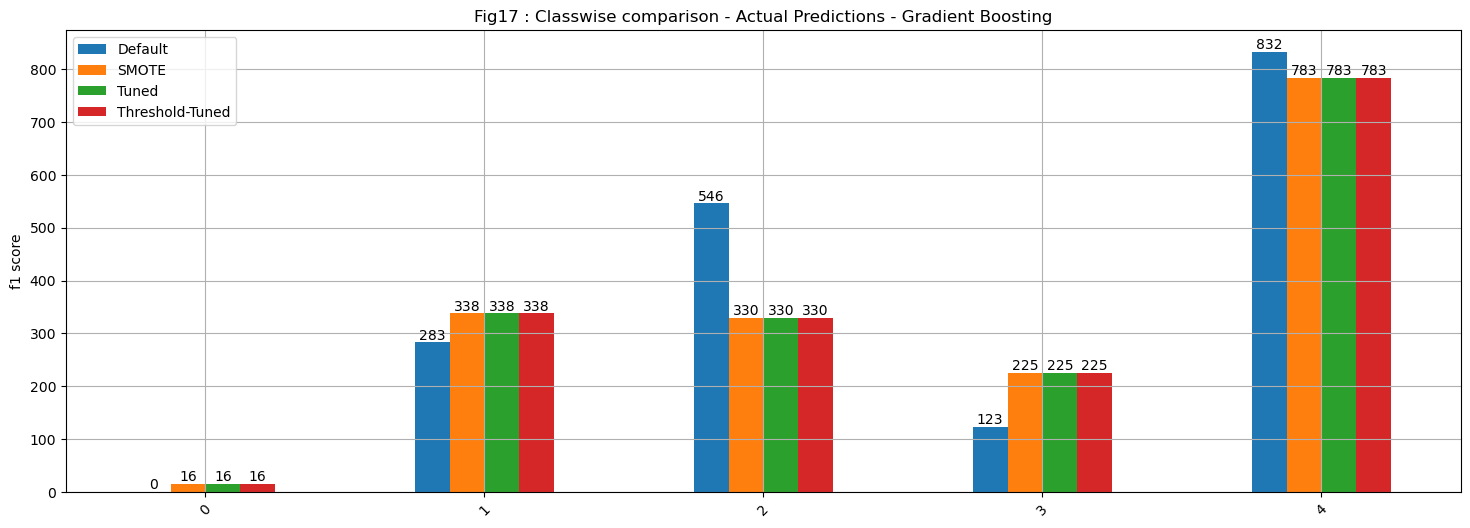

In [114]:
# Capture classification report
config.gbc_f1report_tuned_threshold = cf.get_classification_report(dsholder4, pipelinefactory.gbc, y_preds=xgb_tuned_pred_int)

# Plot Gradient Boosting f1-score difference across all tests
dfs = [config.gbc_f1report, config.gbc_f1report_smote, config.gbc_f1report_tuned, config.gbc_f1report_tuned_threshold]
legends=['Default', 'SMOTE', 'Tuned', 'Threshold-Tuned']
dfdata = zip(dfs, legends)
cf.show_f1_score_comparison(dfdata, f'{model} - Full Comparison', config)

#Capture class details 
config.gbc_classes_arr.append(np.diagonal(confusion_matrix(y_test, gbc_tuned_pred_int, labels=target_classes)))
cf.show_classdata_comparison(config.gbc_classes_arr, target_classes, legends,  f'Actual Predictions - {model}', config)


#### Observations -  GradientBoosting(default  vs  SMOTE  vs  HyperTune  vs HyperTun + ThresholdTunes)
- Again as observed in the other model overall f1-score was not impacted via hypertuning, infact it down 1%
- Class f1-scores 
    - Class 3 shows significant improvement from 20%(default) to 35%
    - For all other classes we see a slight decrease
- Class-wise actual predictions from ConfusionMatrix
    - Class 0 has improved a lot from 0(default) to 16
    - Class 2 sees a big drop from 548 to 336
    - All other classes not much improvement
      
The f1-score may not show significant improvement, but classwise predictions slighly improved. Not a significant improvement overall. 

#### Observation for top 3 clasifiers
- Not a significant improvement in f1-score
- But decent improvement in class-wise predictions.


#### Compare overall class prediction comparison across top models

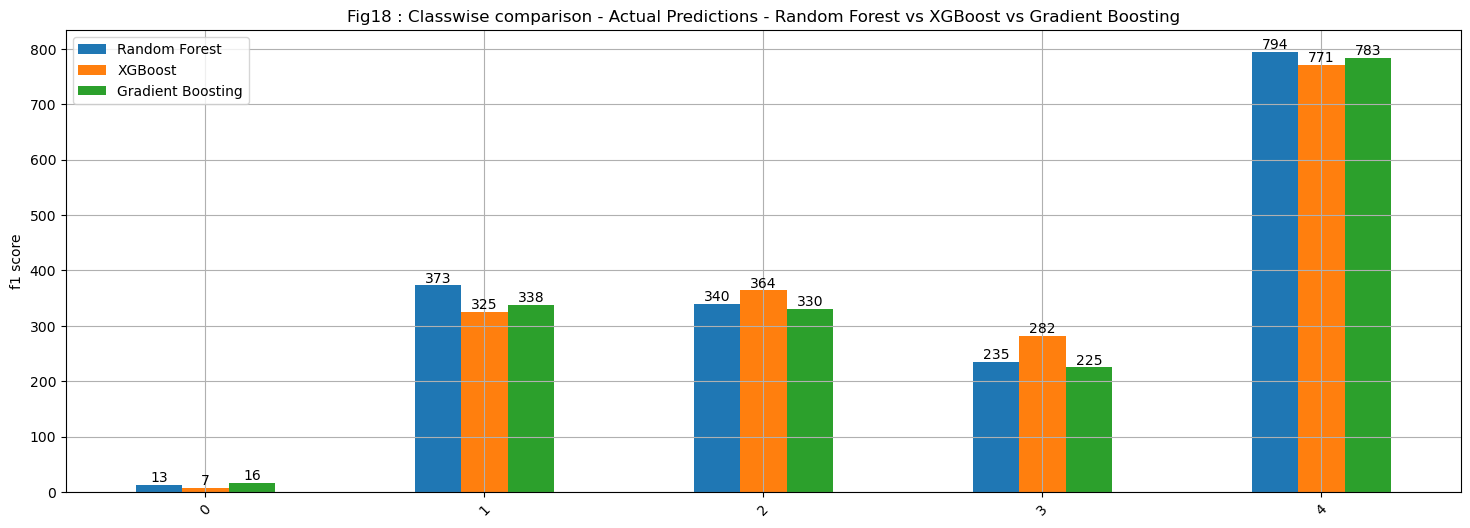

In [118]:
# Classifier comparison for Actual Prediction
dataarr = [config.rnforest_classes_arr[3], config.xgb_classes_arr[3], config.gbc_classes_arr[3]]
legends=['Random Forest', 'XGBoost', 'Gradient Boosting']
cf.show_classdata_comparison(dataarr,
                             target_classes,
                             legends,
                             'Actual Predictions - Random Forest vs XGBoost vs Gradient Boosting',
                             config)


#### Observations
- RandomForest performs the best for Class 1 and 4
- XGBoost for Class 2 and 3
- GradientBoosting for Class 0

Lets try another technique for StackingClassifier to improve the overall score 

#### Stacking Classifier


In [121]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = dsholder4.get()

estimators = [
        ('GradientBoost', pipelinefactory.gbc.best_estimator_.named_steps['classifier']),
        ('RandomTree', pipelinefactory.rnforest.best_estimator_.named_steps['classifier']),
    ]

stackingPipe = Pipeline([
    ('transformer', preprocessor),
    ('classifier', StackingClassifier(estimators=estimators,final_estimator=pipelinefactory.xgb.best_estimator_.named_steps['classifier']))
])

model = 'Stacking Classifier'

In [122]:
stackingPipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['documentSentiment.magnitude',
                                                   'PhotoAmt', 'Fee',
                                                   'Quantity', 'Age',
                                                   'VideoAmt',
                                                   'documentSentiment.score']),
                                                 ('cat',
                                                  TargetEncoder(random_state=42),
                                                  ['Sterilized', 'purebred',
                                                   'Type', 'Vaccinated',
                                                   'FurLength', 'MaturitySize',
                                                   'State'])])),
                ('classifier...
                                                                  gamma=0.3,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=0.01,
                                                                  max_bin=None,
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=1,
                                                                  max_depth=13,
                                                                  max_leaves=None,
                                                                  min_child_weight=1,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=1500,
                                                                  n_jobs=None,
                                                                  num_class=5,
                                                                  num_parallel_tree=None, ...)))])

In [123]:
stackingPipe.fit(X_train, y_train)

[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=13, classifier__min_child_weight=1, classifier__n_estimators=1500, classifier__subsample=0.8; total time=  39.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=13, classifier__min_child_weight=1, classifier__n_estimators=1500, classifier__subsample=0.8; total time=  39.1s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=13, classifier__min_child_weight=1, classifier__n_estimators=1500, classifier__subsample=0.8; total time=  39.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, classifier__learning_rate=0.01, classifier__max_depth=13, classifier__min_child_weight=1, classifier__n_estimators=1500, classifier__subsample=0.8; total time=  37.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.3, cl

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['documentSentiment.magnitude',
                                                   'PhotoAmt', 'Fee',
                                                   'Quantity', 'Age',
                                                   'VideoAmt',
                                                   'documentSentiment.score']),
                                                 ('cat',
                                                  TargetEncoder(random_state=42),
                                                  ['Sterilized', 'purebred',
                                                   'Type', 'Vaccinated',
                                                   'FurLength', 'MaturitySize',
                                                   'State'])])),
                ('classifier...
                                                                  gamma=0.3,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=0.01,
                                                                  max_bin=None,
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=1,
                                                                  max_depth=13,
                                                                  max_leaves=None,
                                                                  min_child_weight=1,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=1500,
                                                                  n_jobs=None,
                                                                  num_class=5,
                                                                  num_parallel_tree=None, ...)))])

In [124]:
y_pred = stackingPipe.predict(X_test)
f1_score(y_test, y_pred, labels=target_classes, average='micro')

0.38541426263558737

Classification Report - Stacking Classifier-f1
              precision    recall  f1-score   support

           0       0.09      0.05      0.06       125
           1       0.33      0.34      0.34       906
           2       0.34      0.33      0.33      1159
           3       0.33      0.24      0.28       886
           4       0.49      0.60      0.54      1257

    accuracy                           0.39      4333
   macro avg       0.32      0.31      0.31      4333
weighted avg       0.37      0.39      0.38      4333



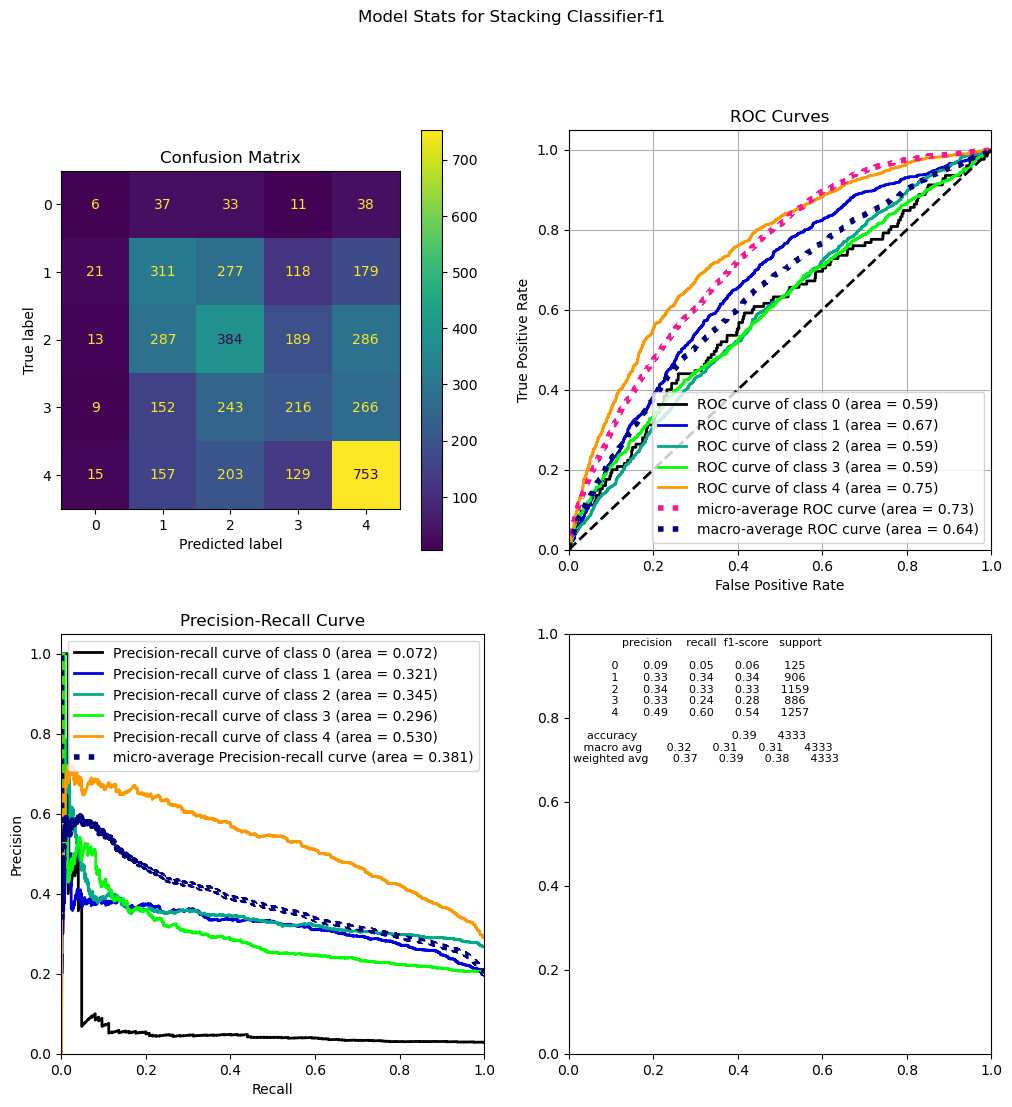

In [125]:
cf.show_logistic_model_stats(dsholder4, stackingPipe,  f'{model}-{scoring_metric}', config)

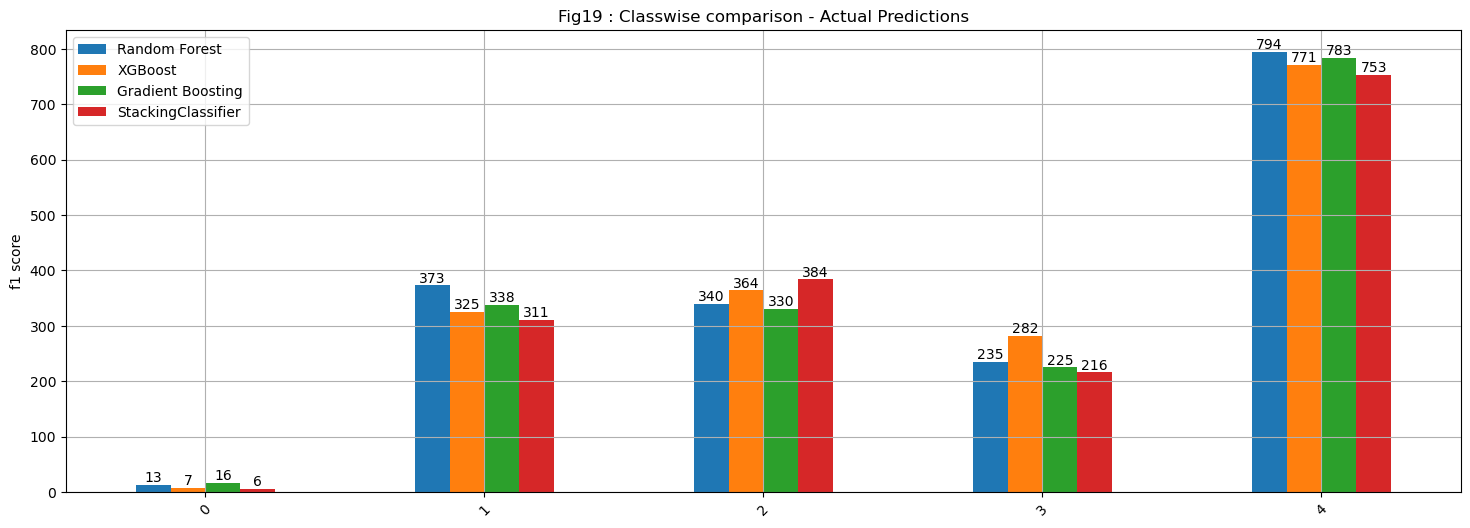

In [126]:
stacking_classifier_classes = np.diagonal(confusion_matrix(y_test, stackingPipe.predict(X_test), labels=target_classes))
dataarr = [config.rnforest_classes_arr[3], config.xgb_classes_arr[3], config.gbc_classes_arr[3], stacking_classifier_classes]
legends=['Random Forest', 'XGBoost', 'Gradient Boosting', 'StackingClassifier']
cf.show_classdata_comparison(dataarr, target_classes, legends,  'Actual Predictions', config)

#### Observations
- Stacking has not really helped in the classification, the f1-score of 38% is stll lower compared to Random Forest Classifier 
- Based on the above class wise predictions, will choose RandomForest as the classifier

## Final Predictions

In [129]:
# Also update the dsholder_final
X_train, X_test, y_train, y_test = dsholder_final.get()
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_train.shape)


(14442, 14)
(3865, 14)
AdoptionSpeed
4    4027
2    3906
3    3176
1    2949
0     384
Name: count, dtype: int64
(14442,)


In [130]:
# Select Random Forest
selected_model = pipelinefactory.rnforest.best_estimator_
selected_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['documentSentiment.magnitude',
                                                   'PhotoAmt', 'Fee',
                                                   'Quantity', 'Age',
                                                   'VideoAmt',
                                                   'documentSentiment.score']),
                                                 ('cat',
                                                  TargetEncoder(random_state=42),
                                                  ['Sterilized', 'purebred',
                                                   'Type', 'Vaccinated',
                                                   'FurLength', 'MaturitySize',
                                                   'State'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=25, max_features=None,
                                        max_samples=0.3, n_estimators=3000,
                                        random_state=42))])

In [131]:
# Fit the model
selected_model.fit(X_train, y_train)

# Calculate the f1-score, based on the training dataset
f1_score(y_test, selected_model.predict(X_train), labels=target_classes, average='micro')

0.6080182800166182

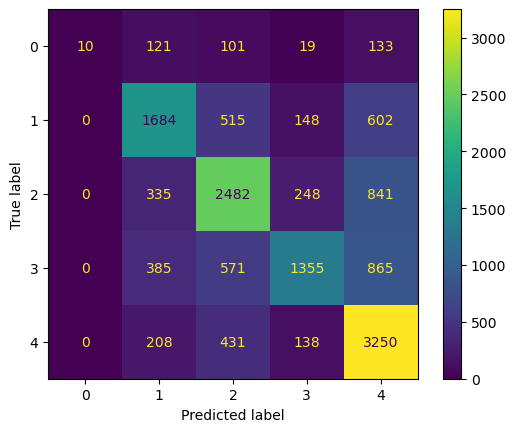

In [132]:
# Dump the confusion matrix
ConfusionMatrixDisplay.from_estimator(selected_model, X_train, y_train);

#### Observations
- We see a big jump in f1-score from 40% we have been seeing across all tests to 60%.
- It might be attributed that we are using the entire training dataset instead of train-test split we did earlier
- Also we are using training for predictions, since we don't have predictions for the test dataset for validation
- Confusion matrix shows the diagonal having the max for most of classes, apart from Class 0 as we have been observing in all tests
- Looks like we made a good choice of model selection

In [134]:
# Final Predictions for the competition
y_pred = selected_model.predict(X_test)
final_submission_df['AdoptionSpeed']  = y_pred

# Save the DataFrame to a CSV file
final_submission_df.to_csv('data2/test/submission.csv', index=False) 

#### Pickle the model for the application

In [137]:
import joblib

# Save the model to be used in an application
joblib.dump(selected_model, 'adoption_speed_model.sav')

['adoption_speed_model.sav']